In [1]:
! pip -q install pandas matplotlib numpy seaborn
! pip install -q scikit-learn
! pip install -q joblib
! pip install -q tensorflow

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
import pandas as pd
import joblib
import os
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import joblib
from scipy import interpolate

time_steps = 28
epochs = 500
batch_size = 8


pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [3]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [4]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'precipitation', 'shutdown', 'mini_shutdown', 'mov_change', 'shops_closed', 'date', 'warehouse', 'winter_school_holidays', 'frankfurt_shutdown', 'holiday_name', 'snow', 'holiday', 'blackout', 'school_holidays'}
No differences found in column: precipitation
No differences found in column: shutdown
No differences found in column: mini_shutdown
No differences found in column: mov_change
No differences found in column: shops_closed
No differences found in column: winter_school_holidays
No differences found in column: frankfurt_shutdown
No differences found in column: holiday_name
No differences found in column: snow
No differences found in column: holiday
No differences found in column: blackout
No differences found in column: school_holidays

Success. All values match across the datasets, datasets merged.
{'warehouse', 'date', 'winter_school_holidays', 'shops_closed', 'holiday_name', 'holiday', 'school_holidays'}
No differences found in column: winter_school_holidays
No differences found

In [5]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [6]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['precipitation', 'shutdown', 'mini_shutdown', 'warehouse_limited', 'mov_change', 'user_activity_1', 'frankfurt_shutdown', 'snow', 'blackout', 'user_activity_2']


In [7]:
train_df = train_df.drop(columns=unavailable_features)

In [8]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [9]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [10]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [11]:
test_df.head()

warehouse       date holiday_name  holiday  shops_closed  \
61        Brno_1 2024-03-16          NaN        0             0   
340   Budapest_1 2024-03-16          NaN        0             0   
292  Frankfurt_1 2024-03-16          NaN        0             0   
244     Munich_1 2024-03-16          NaN        0             0   
0       Prague_1 2024-03-16          NaN        0             0   

     winter_school_holidays  school_holidays                      id  
61                        0                0       Brno_1_2024-03-16  
340                       0                0   Budapest_1_2024-03-16  
292                       0                0  Frankfurt_1_2024-03-16  
244                       0                0     Munich_1_2024-03-16  
0                         0                0     Prague_1_2024-03-16

In [12]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [13]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [14]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [15]:
train_df.head(10)

warehouse       date  orders holiday_name  holiday  shops_closed  \
1193      Brno_1 2020-12-05  6447.0          NaN        0             0   
6186  Budapest_1 2020-12-05  4623.0          NaN        0             0   
0       Prague_1 2020-12-05  6895.0          NaN        0             0   
2386    Prague_2 2020-12-05  4154.0          NaN        0             0   
3579    Prague_3 2020-12-05  4091.0          NaN        0             0   
1194      Brno_1 2020-12-06  5338.0          NaN        0             0   
6187  Budapest_1 2020-12-06  4197.0          NaN        0             0   
1       Prague_1 2020-12-06  6584.0          NaN        0             0   
2387    Prague_2 2020-12-06  4016.0          NaN        0             0   
3580    Prague_3 2020-12-06  3972.0          NaN        0             0   

      winter_school_holidays  school_holidays                     id  
1193                       0                0      Brno_1_2020-12-05  
6186                       0                0  Budapest_1_2020-12-05  
0                          0                0    Prague_1_2020-12-05  
2386                       0                0    Prague_2_2020-12-05  
3579                       0                0    Prague_3_2020-12-05  
1194                       0                0      Brno_1_2020-12-06  
6187                       0                0  Budapest_1_2020-12-06  
1                          0                0    Prague_1_2020-12-06  
2387                       0                0    Prague_2_2020-12-06  
3580                       0                0    Prague_3_2020-12-06

In [16]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    #df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    #df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos']
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    binary_features = ['is_weekend']
    return df, time_features, categorical_features, binary_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [17]:
train_df, time_features, categorical_features, binary_features=process_date(train_df)
binary_features = binary_features + ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']

In [18]:
train_df = train_df.drop(columns=['holiday_name']) 

### Plot

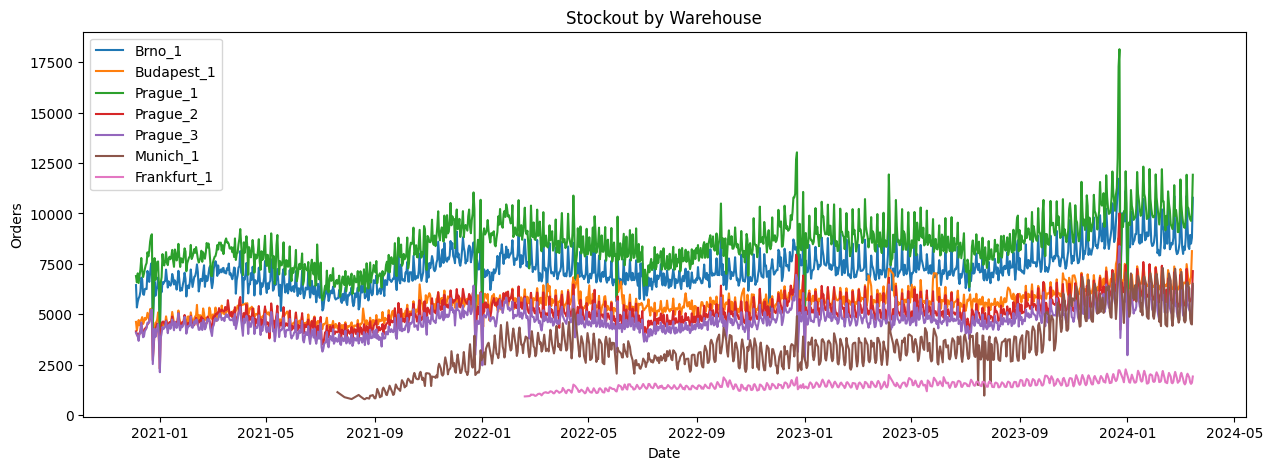

In [19]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

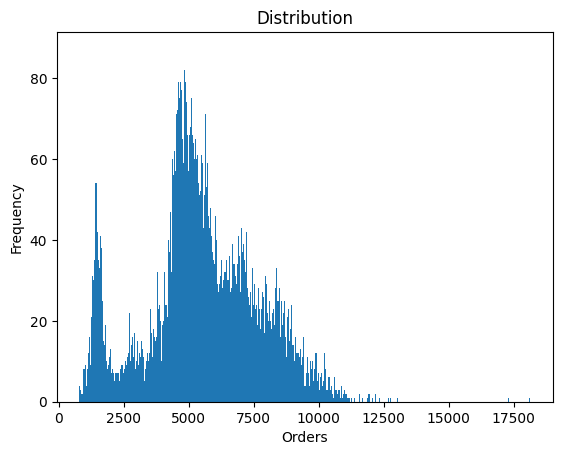

In [20]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

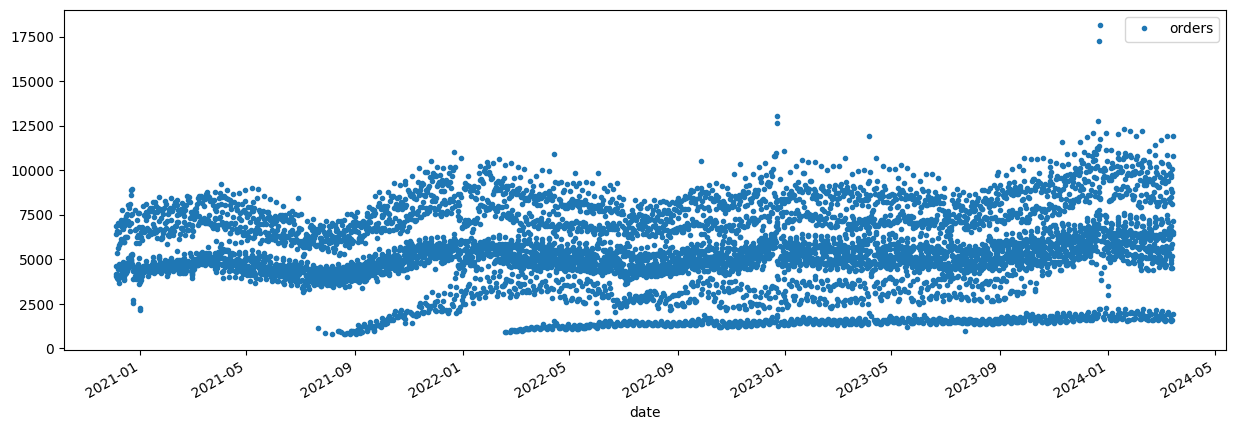

In [21]:
train_df.query('orders > 500').plot(y='orders', figsize=(15, 5), style='.')

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

def z_score_outlier_detection(data, window=14, threshold=3):
    data = data.sort_index()
    rolling_mean = data.rolling(window=window, center=True, min_periods=1).mean()
    rolling_std = data.rolling(window=window, center=True, min_periods=1).std()
    z_scores = (data - rolling_mean) / rolling_std
    outliers = np.abs(z_scores) > threshold
    lower_bound = rolling_mean - (threshold * rolling_std)
    upper_bound = rolling_mean + (threshold * rolling_std)
    return outliers, lower_bound, upper_bound

def fix_outliers(data, outliers, window=14):
    fixed_data = data.copy()
    fixed_data[outliers] = np.nan
    fixed_data = fixed_data.interpolate()
    return fixed_data

def plot_outlier_comparison(train_df, window=28, z_threshold=3):
    warehouses = train_df['warehouse'].unique()
    n_warehouses = len(warehouses)
    
    n_cols = 1
    n_rows = n_warehouses
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 10*n_rows))
    axes = axes.flatten() if n_warehouses > 1 else [axes]
    
    all_z_outliers = pd.Series(dtype=bool)
    
    for idx, warehouse in enumerate(warehouses):
        warehouse_data = train_df[train_df['warehouse'] == warehouse]['orders']
        
        z_outliers, z_lower, z_upper = z_score_outlier_detection(warehouse_data, window, z_threshold)
        fixed_warehouse_data = fix_outliers(warehouse_data, z_outliers, window=window)
        
        # Update the original DataFrame with fixed values
        train_df.loc[train_df['warehouse'] == warehouse, 'orders'] = fixed_warehouse_data
        
        all_z_outliers = pd.concat([all_z_outliers, z_outliers])
        
        # Plot the original data and outliers
        ax = axes[idx]
        ax.plot(warehouse_data.index, warehouse_data, label='Orders', alpha=0.7)
        
        # Plot Z-Score bounds and outliers
        ax.fill_between(warehouse_data.index, z_lower, z_upper, color='green', alpha=0.1, label='Z-Score Bounds')
        ax.scatter(warehouse_data.index[z_outliers], warehouse_data[z_outliers], color='green', label='Z-Score Outliers', marker='s')
        
        # Plot fixed outliers
        ax.scatter(warehouse_data.index[z_outliers], fixed_warehouse_data[z_outliers], color='orange', label='Fixed Outliers', marker='x')

        ax.set_title(f'{warehouse} - Outlier Comparison')
        ax.set_xlabel('Date')
        ax.set_ylabel('Orders')
        ax.legend()
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary of outliers for each warehouse
    for warehouse in warehouses:
        warehouse_data = train_df[train_df['warehouse'] == warehouse]['orders']
        z_outliers, _, _ = z_score_outlier_detection(warehouse_data, window, z_threshold)
        
        print(f"\n{warehouse}:")
        print(f"Z-Score Outliers: {sum(z_outliers)}")
    
    return train_df




C:\Users\ondre\AppData\Local\Temp\ipykernel_11604\1434646546.py:43: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  all_z_outliers = pd.concat([all_z_outliers, z_outliers])


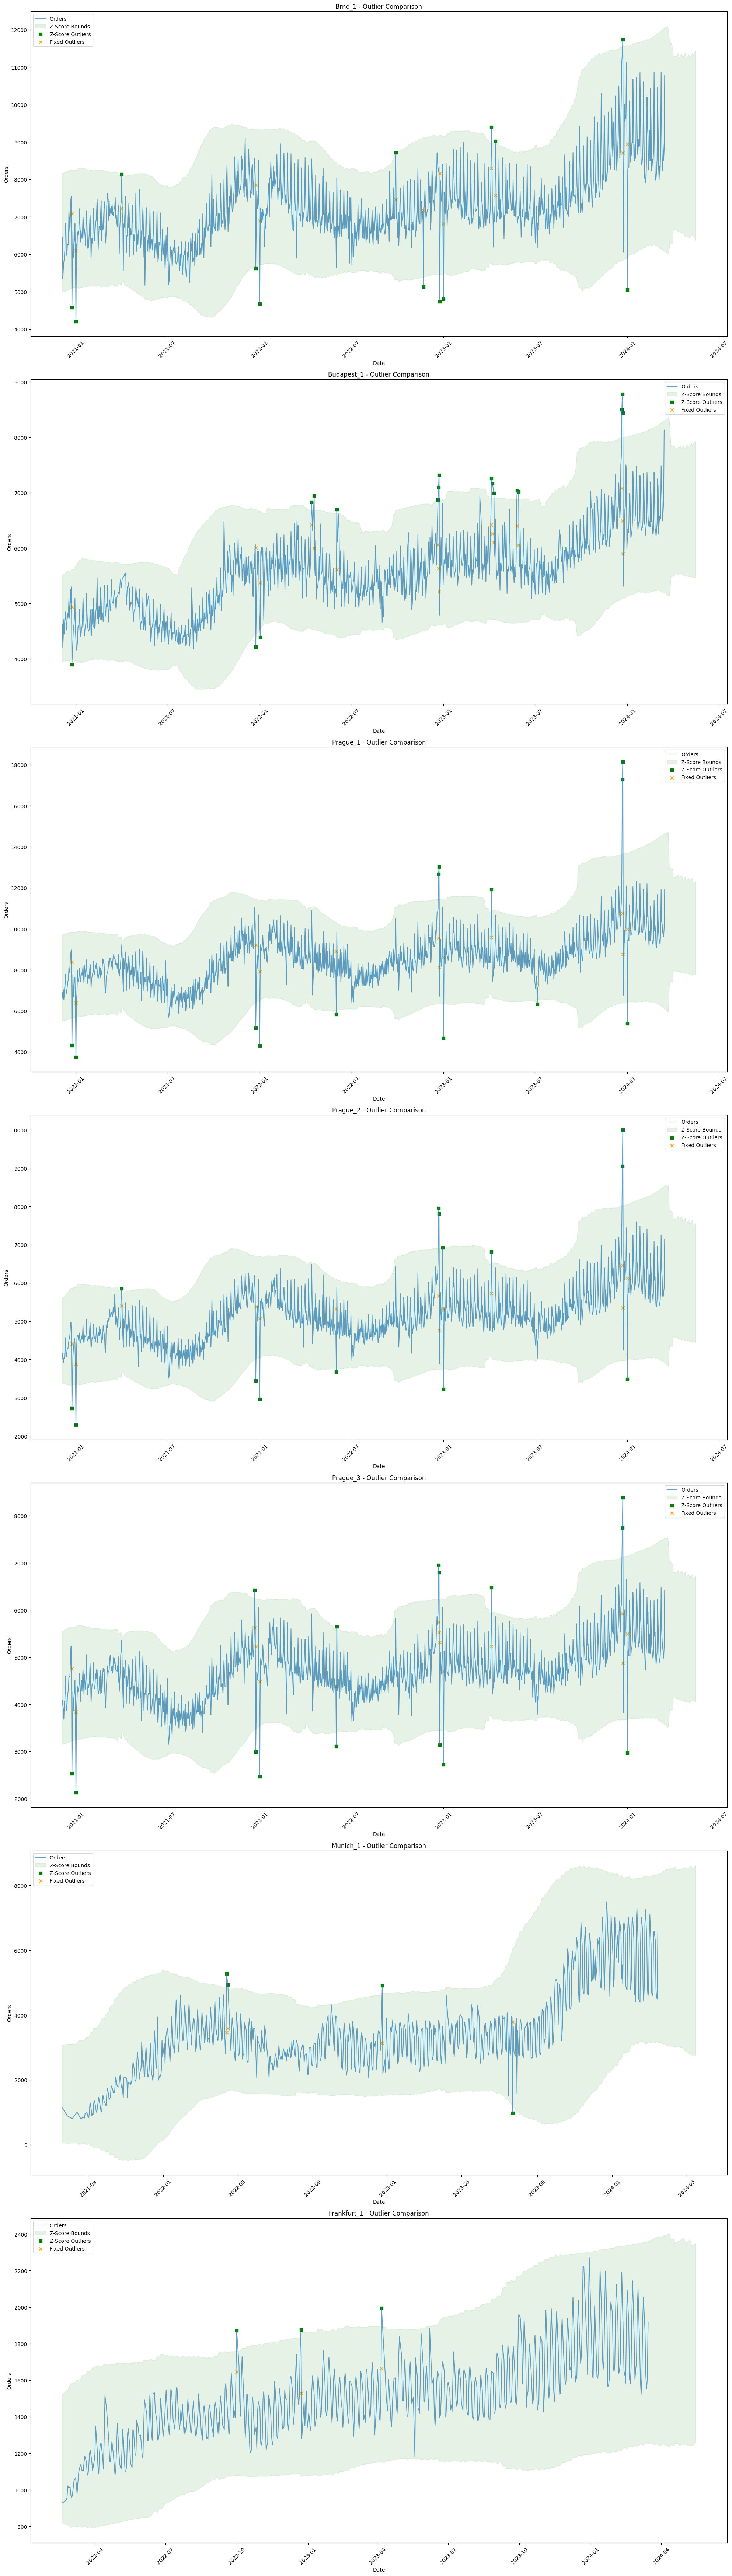


Brno_1:
Z-Score Outliers: 0

Budapest_1:
Z-Score Outliers: 6

Prague_1:
Z-Score Outliers: 6

Prague_2:
Z-Score Outliers: 6

Prague_3:
Z-Score Outliers: 3

Munich_1:
Z-Score Outliers: 1

Frankfurt_1:
Z-Score Outliers: 1


In [23]:
train_df = plot_outlier_comparison(train_df, window=180, z_threshold=2.8)

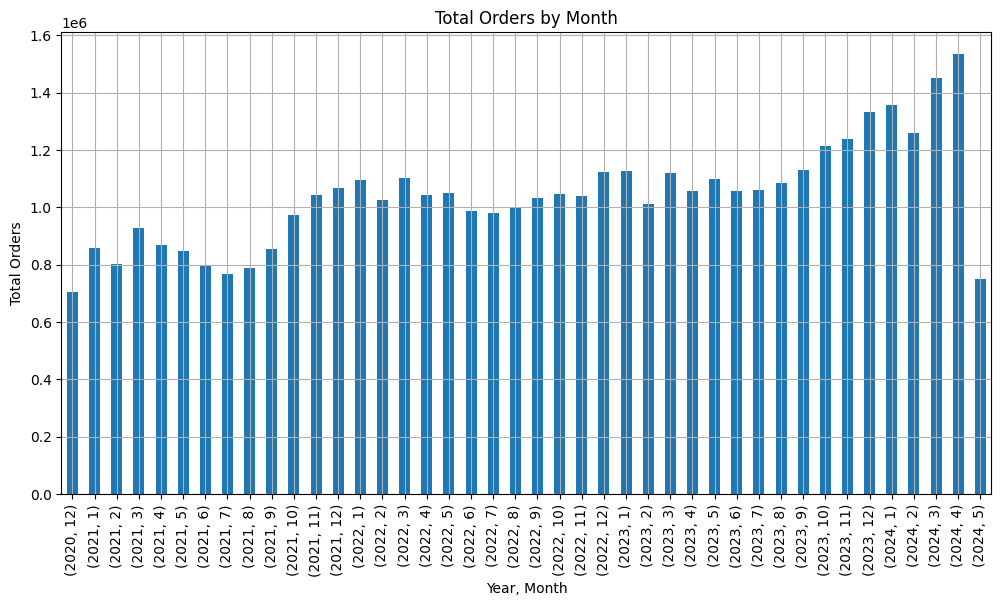

In [24]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

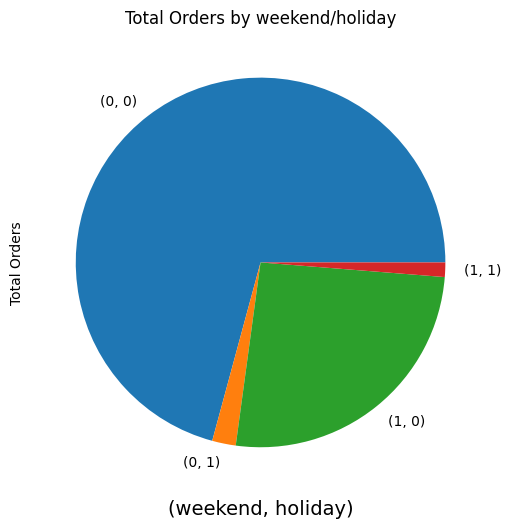

In [25]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [26]:
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

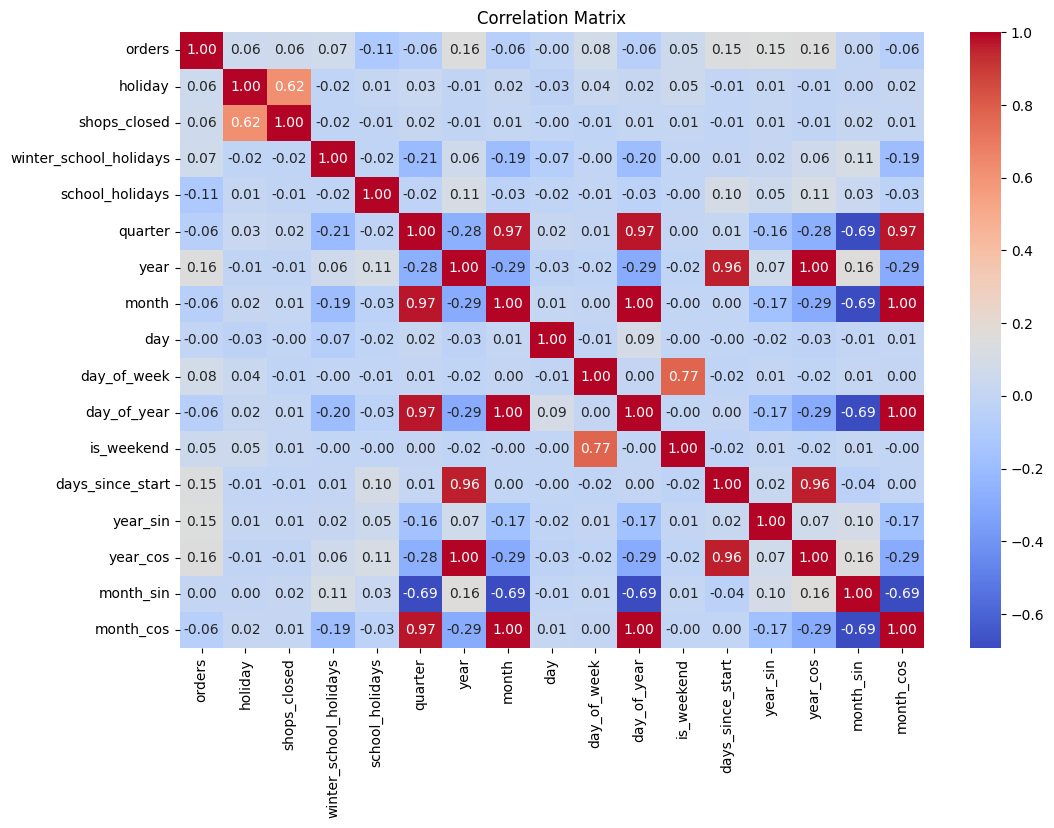

orders                    1.000000
year_cos                  0.157441
year                      0.157441
year_sin                  0.147789
days_since_start          0.145969
day_of_week               0.081944
winter_school_holidays    0.068014
shops_closed              0.062539
holiday                   0.058311
is_weekend                0.048462
month_sin                 0.001280
day                      -0.002302
day_of_year              -0.060822
month                    -0.061573
month_cos                -0.061573
quarter                  -0.062342
school_holidays          -0.113525
Name: orders, dtype: float64


In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Temporal features

In [28]:
LAG_DAYS = [7, 28, 56, 84, 168, 364]
ROLLING_WINDOW = [28, 168, 364]

In [29]:
def create_lag_features(df, col, lag_days):
    df = df.copy() 
    lag_features = []
    for lag in lag_days:
        feature_name = f'{col}_lag_{lag}'
        df[feature_name] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(feature_name)
    return df, lag_features

def create_rolling_features(df, col, windows):
    df = df.copy()
    window_features = []
    for window in windows:
        mean_feature = f'{col}_rolling_mean_{window}'
        std_feature = f'{col}_rolling_std_{window}'
        
        df[mean_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[std_feature] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        
        window_features.extend([mean_feature, std_feature])
    return df, window_features

In [30]:
train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Im putting my features into categories for better manipulation
numerical_features = ['orders']
numerical_features += lag_features + window_features
categorical_features=categorical_features

print(numerical_features)

train_df.head()

['orders', 'orders_lag_7', 'orders_lag_28', 'orders_lag_56', 'orders_lag_84', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


warehouse  orders  holiday  shops_closed  winter_school_holidays  \
date                                                                            
2020-12-05      Brno_1  6447.0        0             0                       0   
2020-12-05  Budapest_1  4623.0        0             0                       0   
2020-12-05    Prague_1  6895.0        0             0                       0   
2020-12-05    Prague_2  4154.0        0             0                       0   
2020-12-05    Prague_3  4091.0        0             0                       0   

            school_holidays                     id  quarter  year  month  day  \
date                                                                            
2020-12-05                0      Brno_1_2020-12-05        4  2020     12    5   
2020-12-05                0  Budapest_1_2020-12-05        4  2020     12    5   
2020-12-05                0    Prague_1_2020-12-05        4  2020     12    5   
2020-12-05                0    Prague_2_2020-12-05        4  2020     12    5   
2020-12-05                0    Prague_3_2020-12-05        4  2020     12    5   

            day_of_week  day_of_year  is_weekend  days_since_start  \
date                                                                 
2020-12-05            5          340           1                 0   
2020-12-05            5          340           1                 0   
2020-12-05            5          340           1                 0   
2020-12-05            5          340           1                 0   
2020-12-05            5          340           1                 0   

                year_sin  year_cos     month_sin  month_cos  orders_lag_7  \
date                                                                        
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   
2020-12-05 -1.630940e-09    2020.0 -3.526983e-14       12.0           NaN   

            orders_lag_28  orders_lag_56  orders_lag_84  orders_lag_168  \
date                                                                      
2020-12-05            NaN            NaN            NaN             NaN   
2020-12-05            NaN            NaN            NaN             NaN   
2020-12-05            NaN            NaN            NaN             NaN   
2020-12-05            NaN            NaN            NaN             NaN   
2020-12-05            NaN            NaN            NaN             NaN   

            orders_lag_364  orders_rolling_mean_28  orders_rolling_std_28  \
date                                                                        
2020-12-05             NaN                  6447.0                    NaN   
2020-12-05             NaN                  4623.0                    NaN   
2020-12-05             NaN                  6895.0                    NaN   
2020-12-05             NaN                  4154.0                    NaN   
2020-12-05             NaN                  4091.0                    NaN   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                   6447.0                     NaN   
2020-12-05                   4623.0                     NaN   
2020-12-05                   6895.0                     NaN   
2020-12-05                   4154.0                     NaN   
2020-12-05                   4091.0                     NaN   

            orders_rolling_mean_364  orders_rolling_std_364  
date                                                         
2020-12-05                   6447.0                     NaN  
2020-12-05                   4623.0                     NaN  
2020-12-05                   6895.0                     NaN  
2020-12-05                  

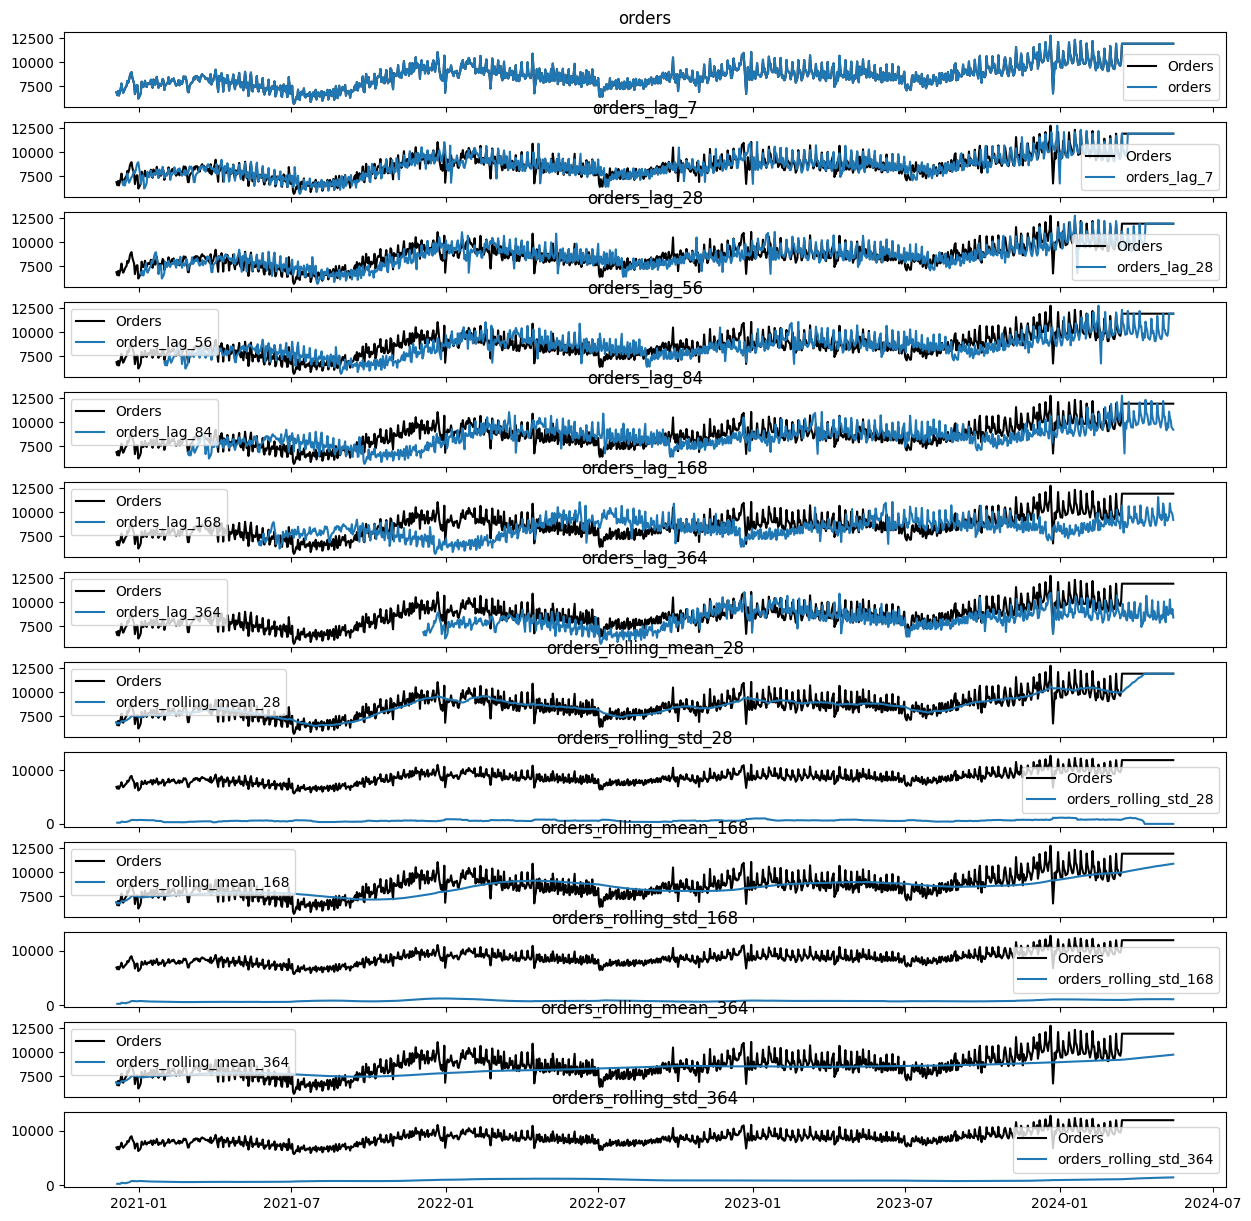

In [31]:
#orders and features above each other (for Prague_1)
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df[train_df.warehouse == 'Prague_1'].index, train_df[train_df.warehouse == 'Prague_1'].orders, label='Orders', color='black')
    ax[i].plot(train_df[train_df.warehouse == 'Prague_1'].index, train_df[train_df.warehouse == 'Prague_1'][feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


In [32]:
# divide dataset back into train and test datasets, for test set to export with new features and train to train on.
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
#test_df["date"] = test_df.index
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

In [33]:
train_df.tail()

warehouse   orders  holiday  shops_closed  \
date                                                      
2024-03-15  Frankfurt_1   1916.0        0             0   
2024-03-15     Munich_1   6512.0        0             0   
2024-03-15     Prague_1  11917.0        0             0   
2024-03-15     Prague_2   7140.0        0             0   
2024-03-15     Prague_3   6408.0        0             0   

            winter_school_holidays  school_holidays                      id  \
date                                                                          
2024-03-15                       0                0  Frankfurt_1_2024-03-15   
2024-03-15                       0                0     Munich_1_2024-03-15   
2024-03-15                       0                0     Prague_1_2024-03-15   
2024-03-15                       0                0     Prague_2_2024-03-15   
2024-03-15                       0                0     Prague_3_2024-03-15   

            quarter  year  month  day  day_of_week  day_of_year  is_weekend  \
date                                                                          
2024-03-15        1  2024      3   15            4           75           0   
2024-03-15        1  2024      3   15            4           75           0   
2024-03-15        1  2024      3   15            4           75           0   
2024-03-15        1  2024      3   15            4           75           0   
2024-03-15        1  2024      3   15            4           75           0   

            days_since_start      year_sin  year_cos     month_sin  month_cos  \
date                                                                            
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   
2024-03-15              1196  3.208798e-11    2024.0 -2.204364e-15        3.0   

            orders_lag_7  orders_lag_28  orders_lag_56  orders_lag_84  \
date                                                                    
2024-03-15        1610.0         1844.0         1611.0         1657.0   
2024-03-15        4694.0         6128.0         6454.0         5824.0   
2024-03-15       11917.0        11095.0        12319.0        12744.0   
2024-03-15        7253.0         6773.0         7590.0         7564.0   
2024-03-15        6473.0         6203.0         6450.0         6974.0   

            orders_lag_168  orders_lag_364  orders_rolling_mean_28  \
date                                                                 
2024-03-15          1639.0          1324.0             1773.750000   
2024-03-15          3501.0          2331.0             5546.464286   
2024-03-15         10668.0          8791.0            10030.214286   
2024-03-15          6605.0          5153.0             5990.928571   
2024-03-15          6086.0          4538.0             5366.750000   

            orders_rolling_std_28  orders_rolling_mean_168  \
date                                                         
2024-03-15             193.275015              1734.309524   
2024-03-15            1036.562463              5184.815476   
2024-03-15             809.959960              9972.467262   
2024-03-15             549.579498              5986.312500   
2024-03-15             466.662351              5391.422619   

            orders_rolling_std_168  orders_rolling_mean_364  \
date                                                          
2024-03-15              199.819168              1619.663462   
2024-03-15             1184.570200              4142.582418   
2024-03-15              935.747306              9222.311813   
2024-03-15              586.376313              5554.064560   
2024-03-15              514.338425              5054.175824   

            orders_rolling_std_364  
date   

In [34]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 31)
Test data: (397, 30)


In [35]:
# Save test datas for future inference
test_df.to_csv('data/test_proc_mt.csv')

In [36]:
train_df = train_df.drop(columns=['id'])

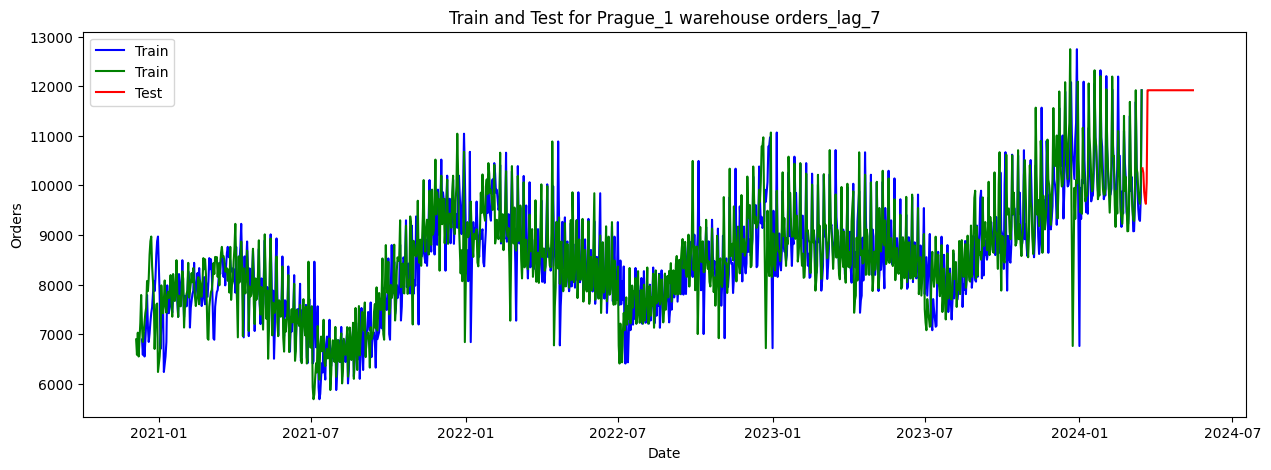

In [37]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
feature = f'orders_lag_{LAG_DAYS[0]}'

plt.figure(figsize=(15, 5)) 
datax = train_df[train_df['warehouse'] == 'Prague_1']
datax_test = test_df[test_df['warehouse'] == 'Prague_1']
plt.plot(datax.index, datax[feature], label='Train', color='blue')
plt.plot(datax.index, datax['orders'], label='Train', color='green')
plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')


plt.title(f'Train and Test for Prague_1 warehouse {feature}')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

In [38]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (7340, 30)
Test data: (397, 30)


In [39]:
print(train_df.isna().sum())  # Check for Nas

warehouse                     0
orders                        0
holiday                       0
shops_closed                  0
winter_school_holidays        0
school_holidays               0
quarter                       0
year                          0
month                         0
day                           0
day_of_week                   0
day_of_year                   0
is_weekend                    0
days_since_start              0
year_sin                      0
year_cos                      0
month_sin                     0
month_cos                     0
orders_lag_7                 49
orders_lag_28               196
orders_lag_56               392
orders_lag_84               588
orders_lag_168             1176
orders_lag_364             2548
orders_rolling_mean_28        0
orders_rolling_std_28         7
orders_rolling_mean_168       0
orders_rolling_std_168        7
orders_rolling_mean_364       0
orders_rolling_std_364        7
dtype: int64


In [40]:
"""lag_roll features
"""
LAG_ROLL_FEATURES = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        LAG_ROLL_FEATURES.append(feature)
print(LAG_ROLL_FEATURES)                                             

['orders_lag_7', 'orders_lag_28', 'orders_lag_56', 'orders_lag_84', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


In [41]:
x_scaler_features = list(set(train_df.columns) - set(categorical_features) - set(binary_features) - {'warehouse', 'orders'})
print(x_scaler_features)

['orders_lag_168', 'month', 'orders_lag_364', 'year_cos', 'year_sin', 'month_sin', 'orders_rolling_mean_28', 'orders_rolling_std_168', 'orders_rolling_mean_168', 'orders_rolling_std_28', 'orders_lag_28', 'month_cos', 'days_since_start', 'orders_lag_56', 'orders_rolling_mean_364', 'day', 'day_of_year', 'orders_lag_7', 'orders_rolling_std_364', 'orders_lag_84']


In [42]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'bin_features': binary_features,
    'cat_features': categorical_features,
    'scaler_features': x_scaler_features,
}

# Save the scaler config
joblib.dump(scaler_config, 'scaler_config.joblib')

['scaler_config.joblib']

In [43]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2020-12-05 00:00:00
End Date: 2024-03-15 00:00:00


In [44]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
0 days    6147
1 days    1188
2 days       4
Name: count, dtype: int64

## Training Loop

In [45]:
train_df = train_df.fillna(0)

In [46]:
train_df.head()

warehouse  orders  holiday  shops_closed  winter_school_holidays  \
date                                                                            
2020-12-05      Brno_1  6447.0        0             0                       0   
2020-12-05  Budapest_1  4623.0        0             0                       0   
2020-12-05    Prague_1  6895.0        0             0                       0   
2020-12-05    Prague_2  4154.0        0             0                       0   
2020-12-05    Prague_3  4091.0        0             0                       0   

            school_holidays  quarter  year  month  day  day_of_week  \
date                                                                  
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   

            day_of_year  is_weekend  days_since_start      year_sin  year_cos  \
date                                                                            
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   

               month_sin  month_cos  orders_lag_7  orders_lag_28  \
date                                                               
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   

            orders_lag_56  orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                                       
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   

            orders_rolling_mean_28  orders_rolling_std_28  \
date                                                        
2020-12-05                  6447.0                    0.0   
2020-12-05                  4623.0                    0.0   
2020-12-05                  6895.0                    0.0   
2020-12-05                  4154.0                    0.0   
2020-12-05                  4091.0                    0.0   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                   6447.0                     0.0   
2020-12-05                   4623.0                     0.0   
2020-12-05                   6895.0                     0.0   
2020-12-05                   4154.0                     0.0   
2020-12-05                   4091.0                     0.0   

            orders_rolling_mean_364  orders_rolling_std_364  
date                                                         
2020-12-05                   6447.0                     0.0  
2020-12-05                   4623.0                     0.0  
2020-12-05                   6895.0                     0.0  
2020-12-05                   4154.0                     0.0  
2020-12-05                   4091.0                     0.0

In [47]:
def preprocess_data(df, cat_features, x_scaler_features, binary_features, inference=False):
    if not inference:
        # Create lag and rolling features
        df, lag_features = create_lag_features(df, 'orders', LAG_DAYS)
        df, window_features = create_rolling_features(df, 'orders', ROLLING_WINDOW)

        # Handle NaN values in lag and rolling features
        df[lag_features + window_features] = df[lag_features + window_features].fillna(method='ffill').fillna(method='bfill')

    # One-hot encoding for categorical features
    if not inference:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoded_features = encoder.fit_transform(df[cat_features])
        joblib.dump(encoder, 'onehot_scaler.joblib')
    else:
        encoder = joblib.load('onehot_scaler.joblib')
        encoded_features = encoder.transform(df[cat_features])

    encoded_feature_names = encoder.get_feature_names_out(cat_features)
    encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names, index=df.index)

    # Prepare features for scaling
    if not inference:
        X = df.drop(columns=['orders'])
        y = df['orders']
    else:
        X = df.copy()

    # Initialize and fit/transform scalers
    if not inference:
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X_scaled = x_scaler.fit_transform(X[x_scaler_features])
        y_scaled = y_scaler.fit_transform(y.values.reshape(-1, 1))
        joblib.dump(x_scaler, 'x_scaler.joblib')
        joblib.dump(y_scaler, 'y_scaler.joblib')
    else:
        x_scaler = joblib.load('x_scaler.joblib')
        X_scaled = x_scaler.transform(X[x_scaler_features])
        y_scaled = None  # No target variable during inference

    # Create DataFrame with scaled features
    X_scaled_df = pd.DataFrame(X_scaled, columns=x_scaler_features, index=df.index)

    # Combine all features
    final_df = pd.concat([
        X_scaled_df,  # Scaled numerical features
        encoded_df,   # One-hot encoded categorical features
        df[binary_features]  # Binary features (unchanged)
    ], axis=1)

    if not inference:
        return final_df, y_scaled
    else:
        return final_df


In [48]:
def create_sequences(X_train_scaled, y_train_scaled, time_steps):
    # Create sequences for each warehouse
    
    sequences = []
    targets = []

    if len(X_train_scaled) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

    X = np.array(sequences)
    y = np.array(targets)

    X = np.squeeze(X, axis=1)
    y = np.squeeze(y, axis=1)
    
    print(f"final shape: {X.shape, y.shape}")
    
    return X, y

In [49]:
def create_model(input_shape, lr=1e-3):

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=32, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(LSTM(units=16, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Dense(units=1))

    model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=lr))

    return model

In [50]:
def plot_loss(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'Training and Validation Loss of {warehouse}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [51]:
X_train_scaled, y_train_scaled = preprocess_data(train_df, categorical_features, x_scaler_features, binary_features)
len(X_train_scaled.columns)

C:\Users\ondre\AppData\Local\Temp\ipykernel_11604\1872044333.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[lag_features + window_features] = df[lag_features + window_features].fillna(method='ffill').fillna(method='bfill')


41

In [52]:
# save scaler_config value 'training_features': training_features:
scaler_config['training_features'] = X_train_scaled.columns.tolist()
# Save the scaler config
joblib.dump(scaler_config, 'scaler_config.joblib')

['scaler_config.joblib']

In [53]:
X_train_scaled.head()

orders_lag_168     month  orders_lag_364  year_cos  year_sin  \
date                                                                       
2020-12-05        0.487094  1.566935        0.453057 -2.277645 -0.249973   
2020-12-05        0.487094  1.566935        0.453057 -2.277645 -0.249973   
2020-12-05        0.487094  1.566935        0.453057 -2.277645 -0.249973   
2020-12-05        0.487094  1.566935        0.453057 -2.277645 -0.249973   
2020-12-05        0.487094  1.566935        0.453057 -2.277645 -0.249973   

            month_sin  orders_rolling_mean_28  orders_rolling_std_168  \
date                                                                    
2020-12-05  -0.575068                0.444727                1.287908   
2020-12-05  -0.575068               -0.416036                1.287908   
2020-12-05  -0.575068                0.656142                1.287908   
2020-12-05  -0.575068               -0.637361                1.287908   
2020-12-05  -0.575068               -0.667091                1.287908   

            orders_rolling_mean_168  orders_rolling_std_28  orders_lag_28  \
date                                                                        
2020-12-05                 0.520412               1.960194       0.431897   
2020-12-05                -0.357618               1.960194       0.431897   
2020-12-05                 0.736068               1.960194       0.431897   
2020-12-05                -0.583383               1.960194       0.431897   
2020-12-05                -0.613710               1.960194       0.431897   

            month_cos  days_since_start  orders_lag_56  \
date                                                     
2020-12-05   1.566935         -1.874899       0.446215   
2020-12-05   1.566935         -1.874899       0.446215   
2020-12-05   1.566935         -1.874899       0.446215   
2020-12-05   1.566935         -1.874899       0.446215   
2020-12-05   1.566935         -1.874899       0.446215   

            orders_rolling_mean_364       day  day_of_year  orders_lag_7  \
date                                                                       
2020-12-05                 0.576988 -1.218257       1.4725      0.424081   
2020-12-05                -0.312812 -1.218257       1.4725      0.424081   
2020-12-05                 0.795536 -1.218257       1.4725      0.424081   
2020-12-05                -0.541604 -1.218257       1.4725      0.424081   
2020-12-05                -0.572337 -1.218257       1.4725      0.424081   

            orders_rolling_std_364  orders_lag_84  day_of_week_0  \
date                                                               
2020-12-05                1.013347       0.461738            0.0   
2020-12-05                1.013347       0.461738            0.0   
2020-12-05                1.013347       0.461738            0.0   
2020-12-05                1.013347       0.461738            0.0   
2020-12-05                1.013347       0.461738            0.0   

            day_of_week_1  day_of_week_2  day_of_week_3  day_of_week_4  \
date                                                                     
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-05            0.0            0.0            0.0            0.0   
2020-12-05            0.0            0.0            0.0            0.0   

            day_of_week_5  day_of_week_6  quarter_1  quarter_2  quarter_3  \
date                                                                        
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-05            1.0            0.0        0.0        0.0        0.0   
2020-12-05            1.0    

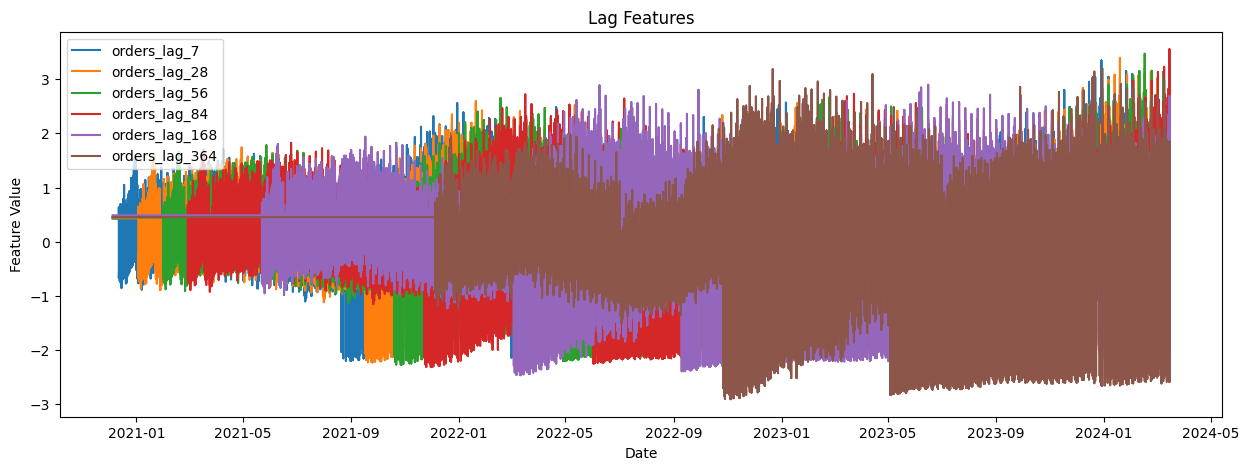

In [54]:
#Plot x_train lag feeatures
plt.figure(figsize=(15, 5))
for feature in lag_features:
    plt.plot(X_train_scaled.index, X_train_scaled[feature], label=feature)
plt.title("Lag Features")
plt.xlabel("Date")
plt.ylabel("Feature Value")
plt.legend()
plt.show()


Training model for warehouse: Brno_1
final shape: ((1186, 7, 41), (1186, 1))
Epoch 1/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.9258
Epoch 1: val_loss improved from inf to 0.29086, saving model to model_Brno_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - loss: 1.9184 - val_loss: 0.2909
Epoch 2/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.8408
Epoch 2: val_loss improved from 0.29086 to 0.12428, saving model to model_Brno_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8381 - val_loss: 0.1243
Epoch 3/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.5831
Epoch 3: val_loss improved from 0.12428 to 0.09526, saving model to model_Brno_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.5806 - val_loss: 0.0953
Epoch 4/10
55/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4498
Epoch 4: val_loss improved from 0.09526 to 0.08482, saving model to model_Brno_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.4499 - val_loss: 0.0848
Epoch 5/10
57/60 ━━━━━━━

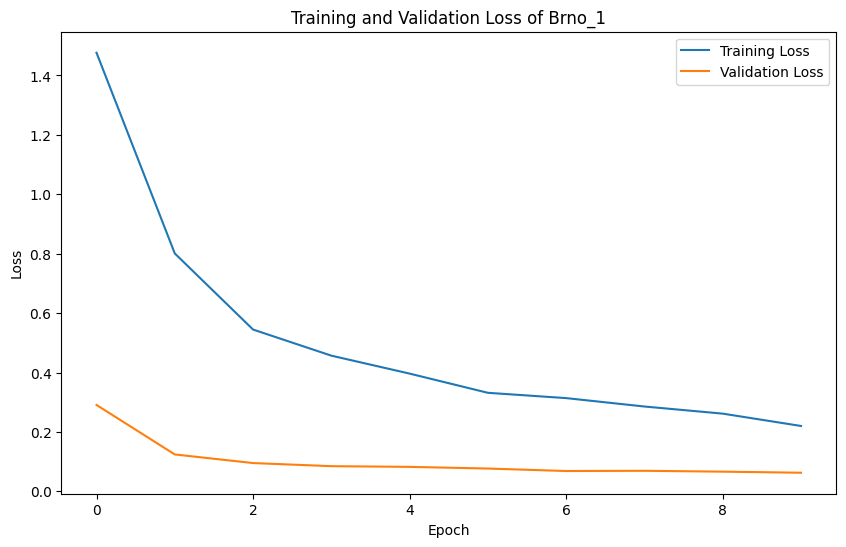

Training model for warehouse: Budapest_1
final shape: ((1147, 7, 41), (1147, 1))
Epoch 1/10
55/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.3310
Epoch 1: val_loss improved from inf to 0.04873, saving model to model_Budapest_1.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 7s 19ms/step - loss: 1.2946 - val_loss: 0.0487
Epoch 2/10
52/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4871
Epoch 2: val_loss improved from 0.04873 to 0.04119, saving model to model_Budapest_1.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4824 - val_loss: 0.0412
Epoch 3/10
56/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3309
Epoch 3: val_loss improved from 0.04119 to 0.03561, saving model to model_Budapest_1.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.3298 - val_loss: 0.0356
Epoch 4/10
53/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2808
Epoch 4: val_loss improved from 0.03561 to 0.02622, saving model to model_Budapest_1.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.2804 - val_loss: 0.0262
Epoch 

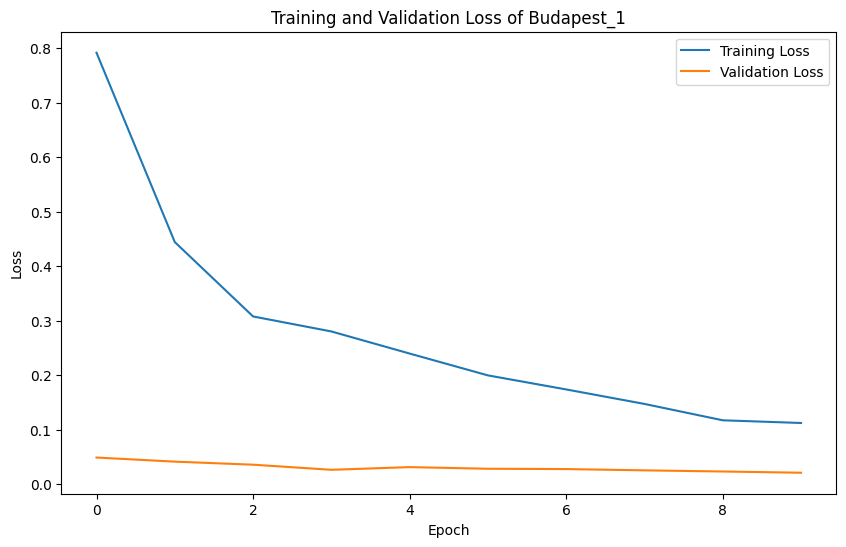

Training model for warehouse: Prague_1
final shape: ((1186, 7, 41), (1186, 1))
Epoch 1/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7631
Epoch 1: val_loss improved from inf to 1.31577, saving model to model_Prague_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 20ms/step - loss: 2.7343 - val_loss: 1.3158
Epoch 2/10
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.6165
Epoch 2: val_loss improved from 1.31577 to 0.94478, saving model to model_Prague_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6095 - val_loss: 0.9448
Epoch 3/10
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1444
Epoch 3: val_loss improved from 0.94478 to 0.64286, saving model to model_Prague_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.1373 - val_loss: 0.6429
Epoch 4/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6773
Epoch 4: val_loss improved from 0.64286 to 0.30811, saving model to model_Prague_1.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.6767 - val_loss: 0.3081
Epoch 5/10
57/6

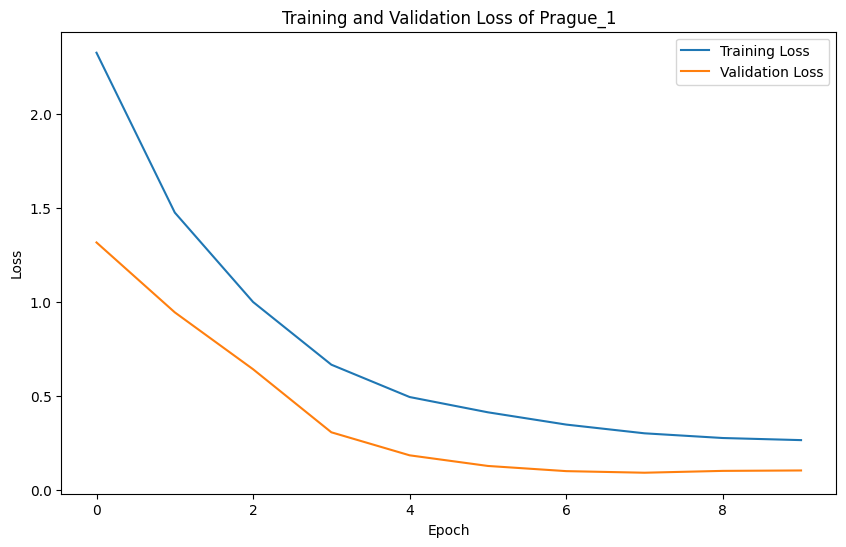

Training model for warehouse: Prague_2
final shape: ((1186, 7, 41), (1186, 1))
Epoch 1/10
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 1.1073
Epoch 1: val_loss improved from inf to 0.07202, saving model to model_Prague_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 1.0696 - val_loss: 0.0720
Epoch 2/10
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.5002
Epoch 2: val_loss did not improve from 0.07202
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4999 - val_loss: 0.0804
Epoch 3/10
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3452
Epoch 3: val_loss improved from 0.07202 to 0.05897, saving model to model_Prague_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3454 - val_loss: 0.0590
Epoch 4/10
57/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3461
Epoch 4: val_loss improved from 0.05897 to 0.05532, saving model to model_Prague_2.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3430 - val_loss: 0.0553
Epoch 5/10
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - los

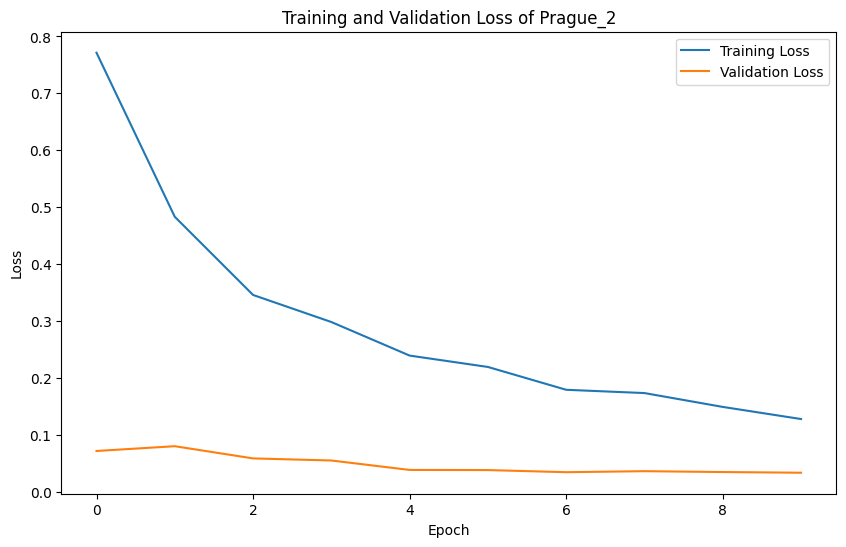

Training model for warehouse: Prague_3
final shape: ((1186, 7, 41), (1186, 1))
Epoch 1/10
58/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.4909
Epoch 1: val_loss improved from inf to 0.06557, saving model to model_Prague_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - loss: 1.4645 - val_loss: 0.0656
Epoch 2/10
59/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.5704
Epoch 2: val_loss did not improve from 0.06557
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5681 - val_loss: 0.0693
Epoch 3/10
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.4637
Epoch 3: val_loss improved from 0.06557 to 0.05021, saving model to model_Prague_3.keras
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4610 - val_loss: 0.0502
Epoch 4/10
56/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.3338
Epoch 4: val_loss did not improve from 0.05021
60/60 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3326 - val_loss: 0.0537
Epoch 5/10
54/60 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2744
Epoch 5: val_loss improved from 0.0

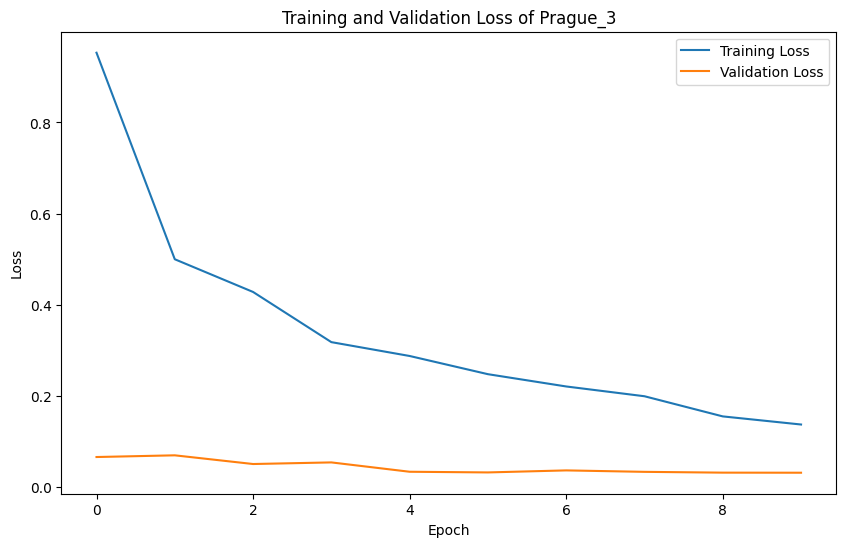

Training model for warehouse: Munich_1
final shape: ((778, 7, 41), (778, 1))
Epoch 1/10
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.1156
Epoch 1: val_loss improved from inf to 0.80489, saving model to model_Munich_1.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 25ms/step - loss: 2.0714 - val_loss: 0.8049
Epoch 2/10
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1.1165
Epoch 2: val_loss improved from 0.80489 to 0.55205, saving model to model_Munich_1.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 1.1116 - val_loss: 0.5520
Epoch 3/10
38/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8180
Epoch 3: val_loss improved from 0.55205 to 0.42517, saving model to model_Munich_1.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.8154 - val_loss: 0.4252
Epoch 4/10
36/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6327
Epoch 4: val_loss improved from 0.42517 to 0.25245, saving model to model_Munich_1.keras
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.6303 - val_loss: 0.2524
Epoch 5/10
36/3

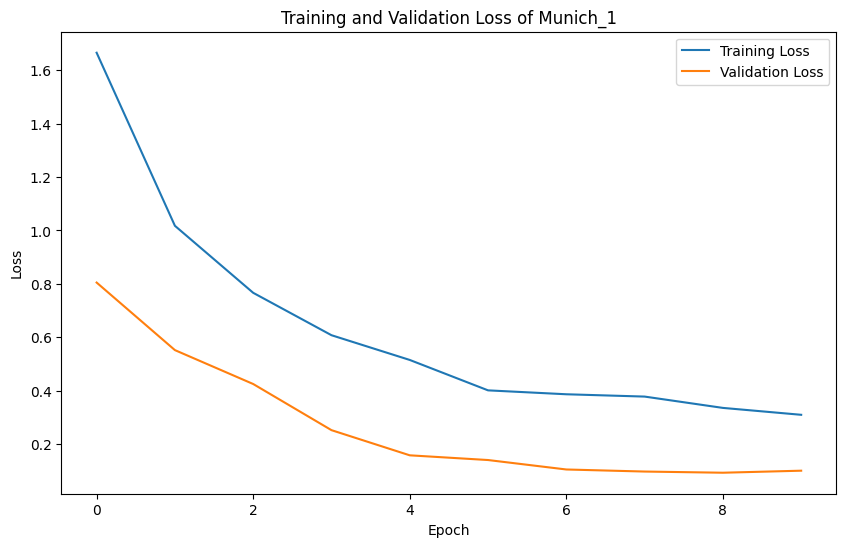

Training model for warehouse: Frankfurt_1
final shape: ((622, 7, 41), (622, 1))
Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 3.7594
Epoch 1: val_loss improved from inf to 2.68126, saving model to model_Frankfurt_1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 31ms/step - loss: 3.7546 - val_loss: 2.6813
Epoch 2/10
31/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 3.2140
Epoch 2: val_loss improved from 2.68126 to 2.34855, saving model to model_Frankfurt_1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 3.2075 - val_loss: 2.3485
Epoch 3/10
25/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.7211
Epoch 3: val_loss improved from 2.34855 to 1.96057, saving model to model_Frankfurt_1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.6981 - val_loss: 1.9606
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2.3113
Epoch 4: val_loss improved from 1.96057 to 1.59433, saving model to model_Frankfurt_1.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 2.3074 - val_loss: 1.5943


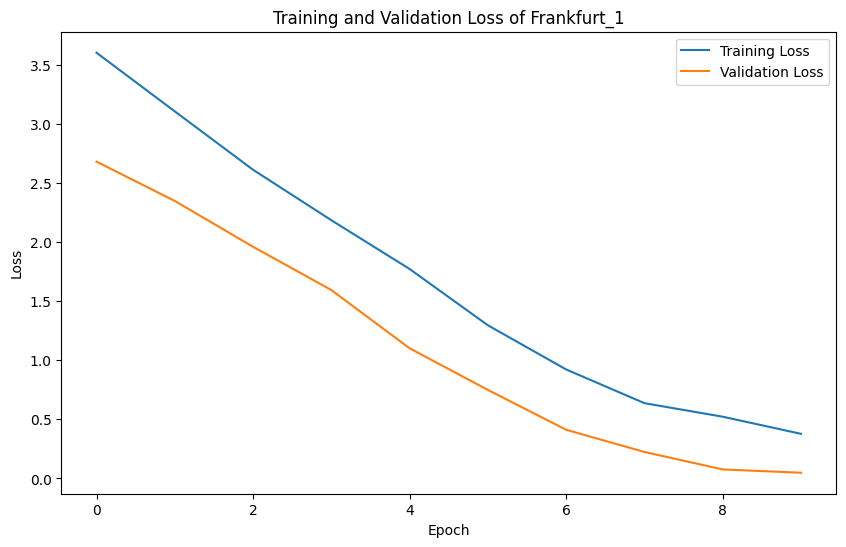

In [55]:
# Train models for each warehouse
warehouses = train_df['warehouse'].unique()

for warehouse in warehouses:
    print(f"Training model for warehouse: {warehouse}")
    
    X_train_wh = X_train_scaled[train_df['warehouse'] == warehouse]
    y_train_wh = y_train_scaled[train_df['warehouse'] == warehouse]
        
    # Create sequences
    X_seq, y_seq = create_sequences(X_train_wh, y_train_wh, time_steps=time_steps)
    
    # Split data
    X_train, X_val, y_train, y_val = train_test_split(X_seq, y_seq, test_size=0.2, shuffle=True, random_state=42)
    
    # Create and train model
    model = create_model(input_shape=(X_train.shape[1], X_train.shape[2]))
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
        ModelCheckpoint(f'model_{warehouse}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
    ]
    
    history = model.fit(
        X_train, y_train, 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_data=(X_val, y_val), 
        callbacks=callbacks,
        verbose=1
    )
    
    plot_loss(history)

## Inference

#### MAPE

In [56]:
train_df.head()

warehouse  orders  holiday  shops_closed  winter_school_holidays  \
date                                                                            
2020-12-05      Brno_1  6447.0        0             0                       0   
2020-12-05  Budapest_1  4623.0        0             0                       0   
2020-12-05    Prague_1  6895.0        0             0                       0   
2020-12-05    Prague_2  4154.0        0             0                       0   
2020-12-05    Prague_3  4091.0        0             0                       0   

            school_holidays  quarter  year  month  day  day_of_week  \
date                                                                  
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   
2020-12-05                0        4  2020     12    5            5   

            day_of_year  is_weekend  days_since_start      year_sin  year_cos  \
date                                                                            
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   
2020-12-05          340           1                 0 -1.630940e-09    2020.0   

               month_sin  month_cos  orders_lag_7  orders_lag_28  \
date                                                               
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   
2020-12-05 -3.526983e-14       12.0           0.0            0.0   

            orders_lag_56  orders_lag_84  orders_lag_168  orders_lag_364  \
date                                                                       
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   
2020-12-05            0.0            0.0             0.0             0.0   

            orders_rolling_mean_28  orders_rolling_std_28  \
date                                                        
2020-12-05                  6447.0                    0.0   
2020-12-05                  4623.0                    0.0   
2020-12-05                  6895.0                    0.0   
2020-12-05                  4154.0                    0.0   
2020-12-05                  4091.0                    0.0   

            orders_rolling_mean_168  orders_rolling_std_168  \
date                                                          
2020-12-05                   6447.0                     0.0   
2020-12-05                   4623.0                     0.0   
2020-12-05                   6895.0                     0.0   
2020-12-05                   4154.0                     0.0   
2020-12-05                   4091.0                     0.0   

            orders_rolling_mean_364  orders_rolling_std_364  
date                                                         
2020-12-05                   6447.0                     0.0  
2020-12-05                   4623.0                     0.0  
2020-12-05                   6895.0                     0.0  
2020-12-05                   4154.0                     0.0  
2020-12-05                   4091.0                     0.0

C:\Users\ondre\AppData\Local\Temp\ipykernel_11604\1872044333.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[lag_features + window_features] = df[lag_features + window_features].fillna(method='ffill').fillna(method='bfill')


Predicting for warehouse: Brno_1
final shape: ((1186, 7, 41), (1186, 1))
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


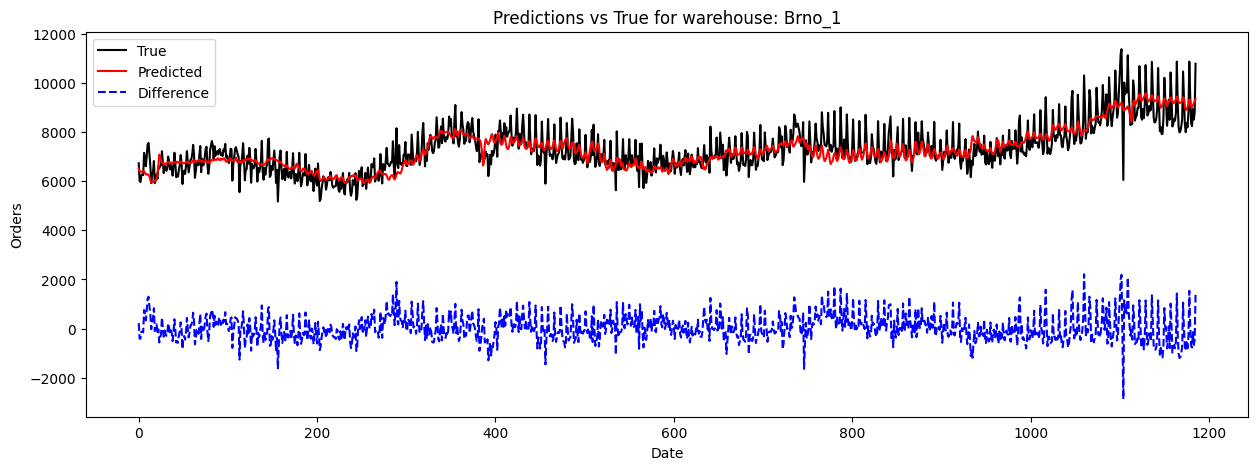


Mean Absolute Percentage Error for Brno_1: 5.3609%
Predicting for warehouse: Budapest_1
final shape: ((1147, 7, 41), (1147, 1))
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


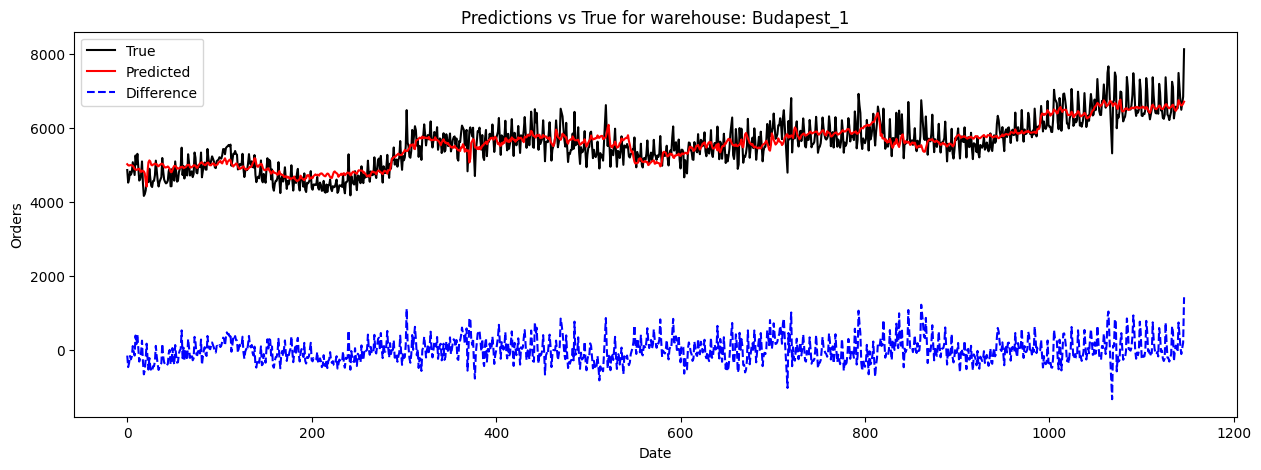


Mean Absolute Percentage Error for Budapest_1: 4.5184%
Predicting for warehouse: Prague_1
final shape: ((1186, 7, 41), (1186, 1))
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


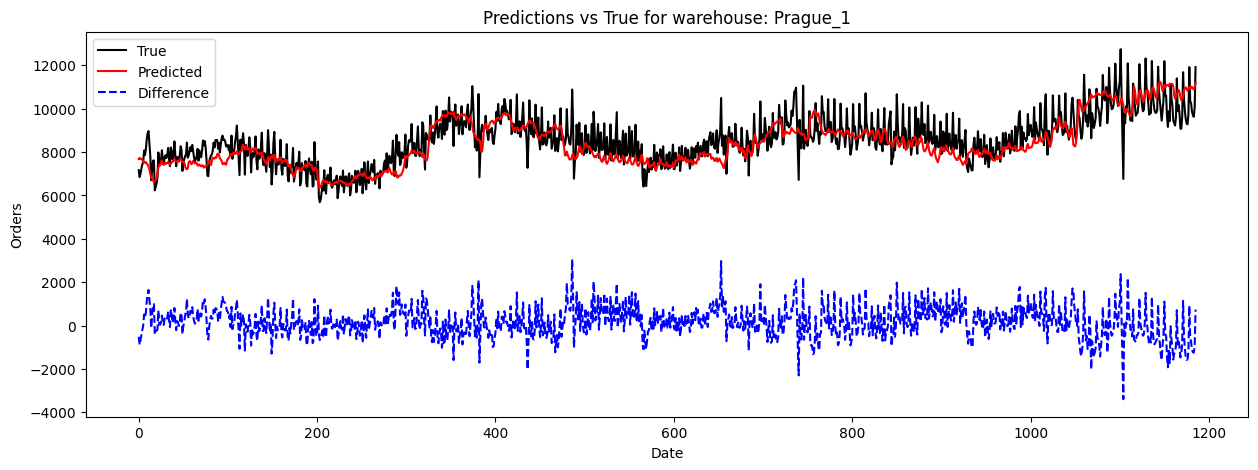


Mean Absolute Percentage Error for Prague_1: 6.2713%
Predicting for warehouse: Prague_2
final shape: ((1186, 7, 41), (1186, 1))
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


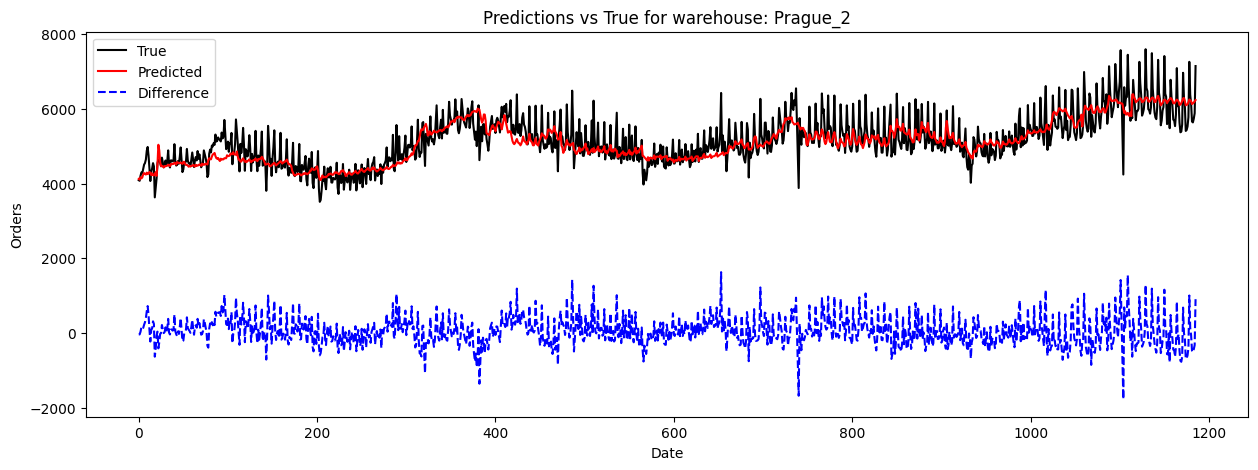


Mean Absolute Percentage Error for Prague_2: 5.3926%
Predicting for warehouse: Prague_3
final shape: ((1186, 7, 41), (1186, 1))
38/38 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


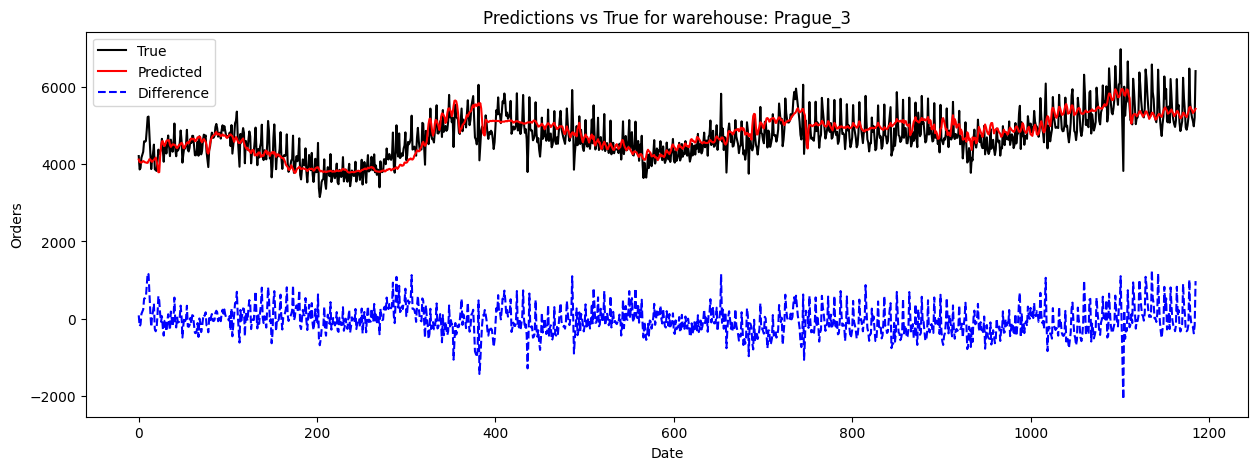


Mean Absolute Percentage Error for Prague_3: 6.0542%
Predicting for warehouse: Munich_1
final shape: ((778, 7, 41), (778, 1))
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step


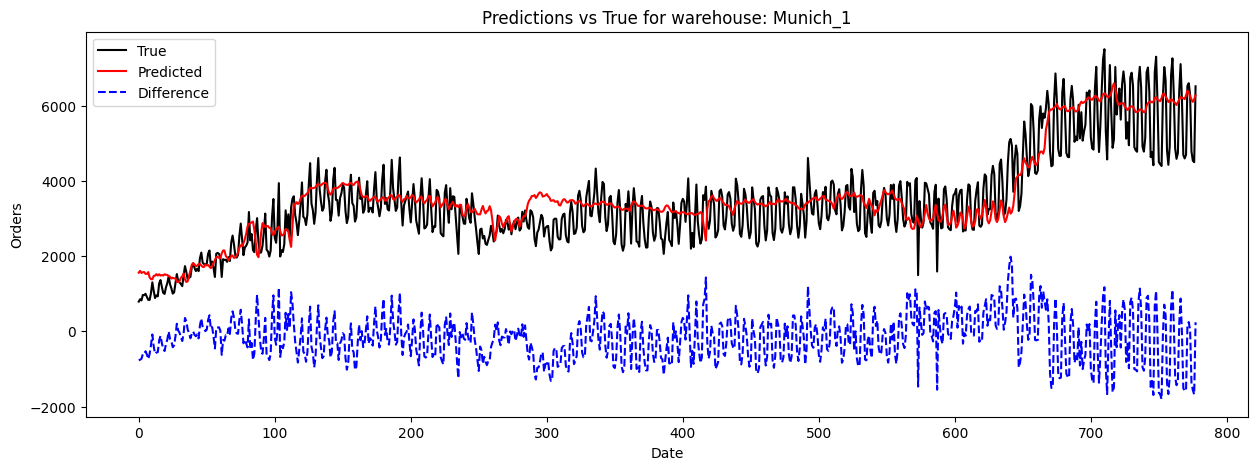


Mean Absolute Percentage Error for Munich_1: 16.6342%
Predicting for warehouse: Frankfurt_1
final shape: ((622, 7, 41), (622, 1))
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


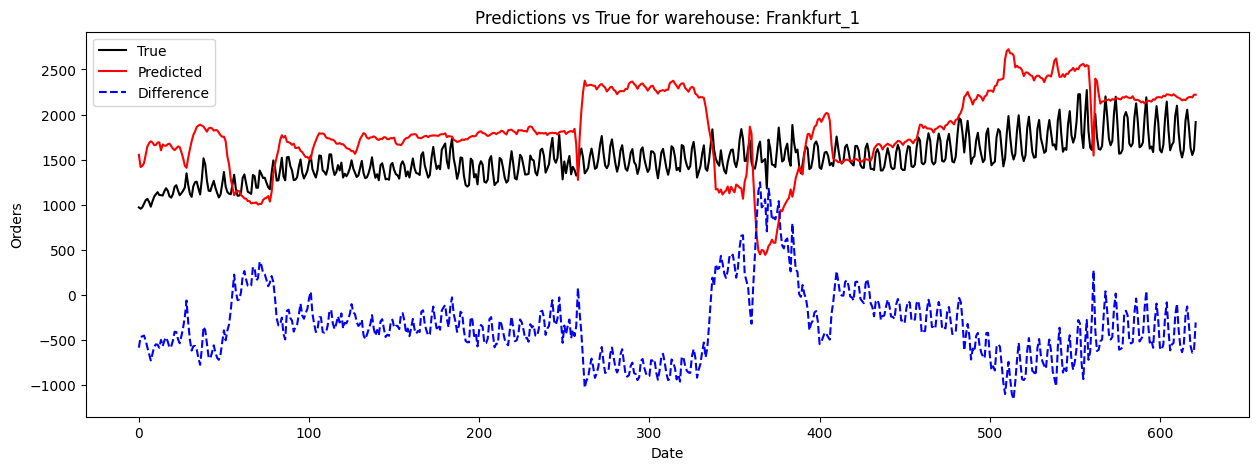


Mean Absolute Percentage Error for Frankfurt_1: 30.0008%

MAPE scores: 
Brno_1: 5.3609%
Budapest_1: 4.5184%
Prague_1: 6.2713%
Prague_2: 5.3926%
Prague_3: 6.0542%
Munich_1: 16.6342%
Frankfurt_1: 30.0008%

Mean MAPE: 10.6046%


In [57]:
# Predict and visualise MAPE for each warehouse with its model and scaler:
mape_scores = []
y_scaler = joblib.load('y_scaler.joblib')
X_train_scaled, y_train_scaled = preprocess_data(train_df, categorical_features, x_scaler_features, binary_features)
    
for warehouse in warehouses:
    print(f"Predicting for warehouse: {warehouse}")
    
    X_train = X_train_scaled[train_df['warehouse'] == warehouse]
    y_train = y_train_scaled[train_df['warehouse'] == warehouse]
    
    # Create sequences
    X_seq, y_seq = create_sequences(X_train, y_train, time_steps=time_steps)
    
    # Load the model
    model = tf.keras.models.load_model(f'model_{warehouse}.keras')
    
    # Predict
    predictions = model.predict(X_seq)
    predictions = y_scaler.inverse_transform(predictions)
    y_seq_unscaled = y_scaler.inverse_transform(y_seq)
    
    # Calculate MAPE
    mape = mean_absolute_percentage_error(y_seq_unscaled, predictions) * 100
    mape_scores.append(mape)
    
    # Visualise the predictions
    plt.figure(figsize=(15, 5))
    plt.plot(y_seq_unscaled, label='True', color='black')
    plt.plot(predictions, label='Predicted', color='red')
    plt.plot(y_seq_unscaled - predictions, label='Difference', color='blue', linestyle='--')
    plt.title(f'Predictions vs True for warehouse: {warehouse}')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.show()
    
    print(f'\nMean Absolute Percentage Error for {warehouse}: {mape:.4f}%')

print("\nMAPE scores: ")
for i, score in enumerate(mape_scores):
    print(f"{warehouses[i]}: {score:.4f}%")

print(f"\nMean MAPE: {np.mean(mape_scores):.4f}%")   

## Inference:

In [58]:
def create_sequences(data, max_time_steps):
    """
    Create variable-length sequences, using all available prior data.
    """
    sequences = []
    for i in range(len(data)):
        seq = data.iloc[max(0, i-max_time_steps+1):i+1].values
        if len(seq) < max_time_steps:
            padding = np.tile(seq[0], (max_time_steps - len(seq), 1))
            seq = np.vstack((padding, seq))
        sequences.append(seq)
    return np.array(sequences)

In [59]:
def variable_length_predict(data, time_steps, warehouse_models, y_scaler, training_features):
    predictions = []
    submission_data = []

    for warehouse in data['warehouse'].unique():
        if warehouse not in warehouse_models:
            print(f"No model found for warehouse: {warehouse}")
            warehouse_predictions = [np.nan] * len(data[data['warehouse'] == warehouse])
            predictions.extend(warehouse_predictions)
            continue

        model = warehouse_models[warehouse]
        wh_data = data[data['warehouse'] == warehouse].copy()
        wh_data = wh_data.reindex(columns=training_features)

        sequences = create_sequences(wh_data, time_steps)
        
        # Predict on all sequences
        preds = model.predict(sequences)
        preds_rescaled = y_scaler.inverse_transform(preds)

        # Align predictions with original data
        wh_predictions = np.full(len(wh_data), np.nan)
        wh_predictions[time_steps-1:] = preds_rescaled.flatten()
        predictions.extend(wh_predictions)

        # Prepare submission data
        wh_submission_data = data.loc[data['warehouse'] == warehouse].copy()
        wh_submission_data['predicted_orders'] = wh_predictions
        submission_data.append(wh_submission_data)

    submission_df = pd.concat(submission_data)
    return np.array(predictions), submission_df


In [60]:
def load_models_and_scalers(warehouses):
    warehouse_models = {}
    for wh in warehouses:
        try:
            model = tf.keras.models.load_model(f'model_{wh}.keras')
            warehouse_models[wh] = model
        except Exception as e:
            print(f"Error loading model for warehouse {wh}: {str(e)}")
    return warehouse_models

In [61]:
dataframe = pd.read_csv("data/test_proc_mt.csv")
dataframe['date'] = pd.to_datetime(dataframe['date'])
dataframe = dataframe.sort_values(by=['date', 'warehouse'])
dataframe.head()

date    warehouse  holiday  shops_closed  winter_school_holidays  \
0 2024-03-16       Brno_1        0             0                       0   
1 2024-03-16   Budapest_1        0             0                       0   
2 2024-03-16  Frankfurt_1        0             0                       0   
3 2024-03-16     Munich_1        0             0                       0   
4 2024-03-16     Prague_1        0             0                       0   

   school_holidays                      id  quarter  year  month  day  \
0                0       Brno_1_2024-03-16        1  2024      3   16   
1                0   Budapest_1_2024-03-16        1  2024      3   16   
2                0  Frankfurt_1_2024-03-16        1  2024      3   16   
3                0     Munich_1_2024-03-16        1  2024      3   16   
4                0     Prague_1_2024-03-16        1  2024      3   16   

   day_of_week  day_of_year  is_weekend  days_since_start      year_sin  \
0            5           76           1              1197  3.208798e-11   
1            5           76           1              1197  3.208798e-11   
2            5           76           1              1197  3.208798e-11   
3            5           76           1              1197  3.208798e-11   
4            5           76           1              1197  3.208798e-11   

   year_cos     month_sin  month_cos  orders_lag_7  orders_lag_28  \
0    2024.0 -2.204364e-15        3.0        9419.0         9529.0   
1    2024.0 -2.204364e-15        3.0        7488.0         7193.0   
2    2024.0 -2.204364e-15        3.0        1930.0         1623.0   
3    2024.0 -2.204364e-15        3.0        6523.0         4499.0   
4    2024.0 -2.204364e-15        3.0       10344.0        10488.0   

   orders_lag_56  orders_lag_84  orders_lag_168  orders_lag_364  \
0         9512.0        11368.0          8045.0          7910.0   
1         7481.0         7492.0          5839.0          6047.0   
2         1652.0         1669.0          1427.0          1354.0   
3         5627.0         5067.0          3906.0          2448.0   
4        10968.0        10750.0          8806.0          9817.0   

   orders_rolling_mean_28  orders_rolling_std_28  orders_rolling_mean_168  \
0             8909.321429             951.304603              8743.699405   
1             6749.678571             526.409364              6531.068452   
2             1784.214286             192.741884              1737.220238   
3             5618.357143            1031.015760              5200.327381   
4            10081.250000             881.715736              9990.985119   

   orders_rolling_std_168  orders_rolling_mean_364  orders_rolling_std_364  
0              960.369783              7975.304945             1040.427470  
1              460.501368              6121.530220              550.190403  
2              198.875203              1621.207418              194.010902  
3             1184.786600              4153.747253             1319.545306  
4              943.277498              9228.081044             1080.219256

In [62]:
# load scaler config:
scaler_config = joblib.load('scaler_config.joblib') # load the scaler config
ohsc = joblib.load("scaler_onehot_categorical.joblib")   # OneHotEncoder for categorical features

x_scaler_features = scaler_config['scaler_features']   # standard scaler features in the right order that the training dataset was scaled on
categorical_features = scaler_config['cat_features']    # categorical features
binary_features = scaler_config['bin_features']    # binary features are unpluged before scaling and then plugged back in after scaling
training_features = scaler_config['training_features']
    
print(f"cat_features: {categorical_features}")
print(f"binary_features: {binary_features}")
print(f"scaler_columns: {len(x_scaler_features)}")

cat_features: ['day_of_week', 'quarter', 'year']
binary_features: ['is_weekend', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays']
scaler_columns: 20


In [63]:
id = dataframe['id']
date = dataframe['date']
warehouse = dataframe["warehouse"]

In [64]:
processed_data = preprocess_data(dataframe, categorical_features, x_scaler_features, binary_features, inference=True)
processed_data = pd.concat([warehouse, processed_data], axis=1)
processed_data = processed_data.set_index(dataframe.date)
len(processed_data.columns)

42

In [65]:
processed_data.head(8)

warehouse  orders_lag_168     month  orders_lag_364  year_cos  \
date                                                                          
2024-03-16       Brno_1        1.321040 -0.941954        1.322406  1.925212   
2024-03-16   Budapest_1        0.169797 -0.941954        0.215368  1.925212   
2024-03-16  Frankfurt_1       -2.132689 -0.941954       -2.573323  1.925212   
2024-03-16     Munich_1       -0.838976 -0.941954       -1.923243  1.925212   
2024-03-16     Prague_1        1.718183 -0.941954        2.455591  1.925212   
2024-03-16     Prague_2       -0.061913 -0.941954        0.128611  1.925212   
2024-03-16     Prague_3       -0.298319 -0.941954       -0.283780  1.925212   
2024-03-17       Brno_1        0.836746 -0.941954        1.038368  1.925212   

            year_sin  month_sin  orders_rolling_mean_28  \
date                                                      
2024-03-16  1.448262   0.610463                1.606719   
2024-03-16  1.448262   0.610463                0.587564   
2024-03-16  1.448262   0.610463               -1.755685   
2024-03-16  1.448262   0.610463                0.053683   
2024-03-16  1.448262   0.610463                2.159764   
2024-03-16  1.448262   0.610463                0.243205   
2024-03-16  1.448262   0.610463               -0.054014   
2024-03-17  1.448262   0.610463                1.649781   

            orders_rolling_std_168  orders_rolling_mean_168  \
date                                                          
2024-03-16                2.072913                 1.625988   
2024-03-16               -0.154246                 0.560880   
2024-03-16               -1.319920                -1.746763   
2024-03-16                3.072801                -0.079706   
2024-03-16                1.996759                 2.226401   
2024-03-16                0.428410                 0.303648   
2024-03-16                0.106759                 0.016483   
2024-03-17                2.092432                 1.636475   

            orders_rolling_std_28  orders_lag_28  month_cos  days_since_start  \
date                                                                            
2024-03-16               2.831490       1.881551  -0.941954          1.683105   
2024-03-16               0.616301       0.782786  -0.941954          1.683105   
2024-03-16              -1.123273      -1.837127  -0.941954          1.683105   
2024-03-16               3.247064      -0.484367  -0.941954          1.683105   
2024-03-16               2.468689       2.332627  -0.941954          1.683105   
2024-03-16               0.938018       0.375453  -0.941954          1.683105   
2024-03-16               0.488172       0.105466  -0.941954          1.683105   
2024-03-17               3.106286       1.266788  -0.941954          1.686077   

            orders_lag_56  orders_rolling_mean_364       day  day_of_year  \
date                                                                        
2024-03-16       1.917883                 1.322540  0.036842    -0.935530   
2024-03-16       0.942693                 0.418215  0.036842    -0.935530   
2024-03-16      -1.856118                -1.777174  0.036842    -0.935530   
2024-03-16       0.052490                -0.541727  0.036842    -0.935530   
2024-03-16       2.616986                 1.933681  0.036842    -0.935530   
2024-03-16       0.497591                 0.143049  0.036842    -0.935530   
2024-03-16       0.332899                -0.100862  0.036842    -0.935530   
2024-03-17       1.512634                 1.327023  0.150941    -0.926408   

            orders_lag_7  orders_rolling_std_364  orders_lag_84  \
date                                                              
2024-03-16      1.803106                2.074735       2.877583   
2024-03-16      0.907111                0.044141       0.974755   
2024-03-16     -1.671831               -1.431178      -1.883905   
2024-03-16      0.459346                3.230860      -0.215740   
2024-03-16      2

In [66]:
# Load models and scalers
warehouses = processed_data['warehouse'].unique()
warehouse_models = load_models_and_scalers(warehouses)
y_scaler = joblib.load('y_scaler.joblib')

In [71]:
predictions, submission_df = variable_length_predict(processed_data, time_steps, warehouse_models, y_scaler, training_features)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 519ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 544ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 503ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 536ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 683ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step


In [72]:
# Align 'id' and 'date' with the original dataframe
dataframe = dataframe.set_index('date')
submission_df['id'] = submission_df.index.map(lambda x: dataframe.loc[x, 'id'] if x in dataframe.index else np.nan)
submission_df['date'] = submission_df.index

# Save submission CSV
submission_df.to_csv('submission_multi_warehouse.csv', index=False)

In [73]:
submission_df.head()

warehouse  orders_lag_168     month  orders_lag_364  year_cos  \
date                                                                       
2024-03-16    Brno_1        1.321040 -0.941954        1.322406  1.925212   
2024-03-17    Brno_1        0.836746 -0.941954        1.038368  1.925212   
2024-03-18    Brno_1        0.957820 -0.941954        0.961713  1.925212   
2024-03-19    Brno_1        0.925464 -0.941954        0.844651  1.925212   
2024-03-20    Brno_1        0.825787 -0.941954        0.662224  1.925212   

            year_sin  month_sin  orders_rolling_mean_28  \
date                                                      
2024-03-16  1.448262   0.610463                1.606719   
2024-03-17  1.448262   0.610463                1.649781   
2024-03-18  1.448262   0.610463                1.691090   
2024-03-19  1.448262   0.610463                1.728809   
2024-03-20  1.448262   0.610463                1.767843   

            orders_rolling_std_168  orders_rolling_mean_168  \
date                                                          
2024-03-16                2.072913                 1.625988   
2024-03-17                2.092432                 1.636475   
2024-03-18                2.119584                 1.646297   
2024-03-19                2.142133                 1.656297   
2024-03-20                2.154079                 1.666844   

            orders_rolling_std_28  orders_lag_28  month_cos  days_since_start  \
date                                                                            
2024-03-16               2.831490       1.881551  -0.941954          1.683105   
2024-03-17               3.106286       1.266788  -0.941954          1.686077   
2024-03-18               3.340127       1.315706  -0.941954          1.689050   
2024-03-19               3.554268       1.415893  -0.941954          1.692022   
2024-03-20               3.719916       1.379205  -0.941954          1.694995   

            orders_lag_56  orders_rolling_mean_364       day  day_of_year  \
date                                                                        
2024-03-16       1.917883                 1.322540  0.036842    -0.935530   
2024-03-17       1.512634                 1.327023  0.150941    -0.926408   
2024-03-18       1.544805                 1.331679  0.265041    -0.917287   
2024-03-19       1.702775                 1.336599  0.379141    -0.908166   
2024-03-20       1.609625                 1.341930  0.493241    -0.899044   

            orders_lag_7  orders_rolling_std_364  orders_lag_84  \
date                                                              
2024-03-16      1.803106                2.074735       2.877583   
2024-03-17      1.312188                2.115796       1.571966   
2024-03-18      1.253723                2.155273       0.266349   
2024-03-19      1.577135                2.192362       2.212379   
2024-03-20      1.378541                2.225298       1.980662   

            day_of_week_0  day_of_week_1  day_of_week_2  day_of_week_3  \
date                                                                     
2024-03-16            0.0            0.0            0.0            0.0   
2024-03-17            0.0            0.0            0.0            0.0   
2024-03-18            1.0            0.0            0.0            0.0   
2024-03-19            0.0            1.0            0.0            0.0   
2024-03-20            0.0            0.0            1.0            0.0   

            day_of_week_4  day_of_week_5  day_of_week_6  quarter_1  quarter_2  \
date                                                                            
2024-03-16            0.0            1.0            0.0        1.0        0.0   
2024-03-17            0.0            0.0            1.0        1.0        0.0   
2024-03-18            0.0            0.0            0.0        1.0        0.0   
2024-03-19            0.0            0.0            0.0        1.0        0.0   
2024-03-20            0.0            0.

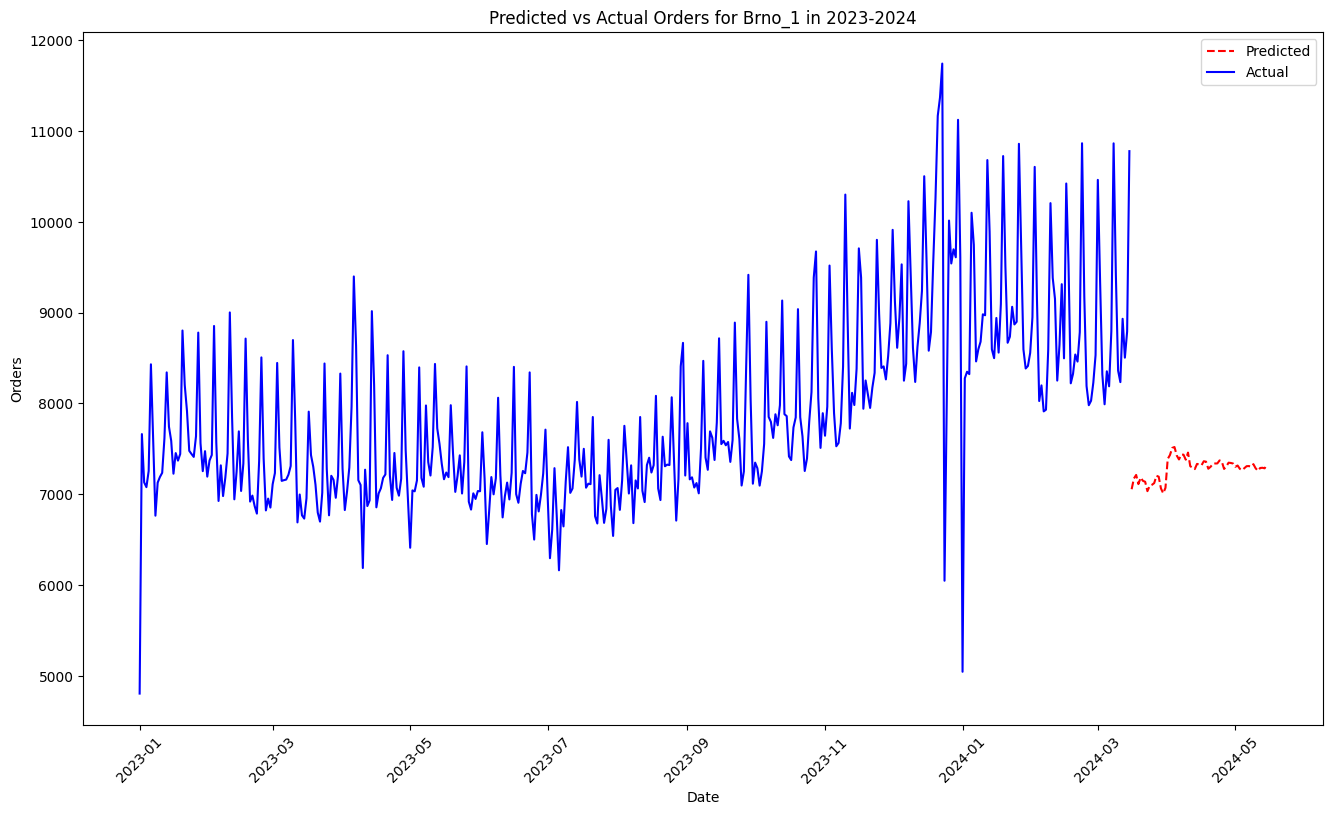

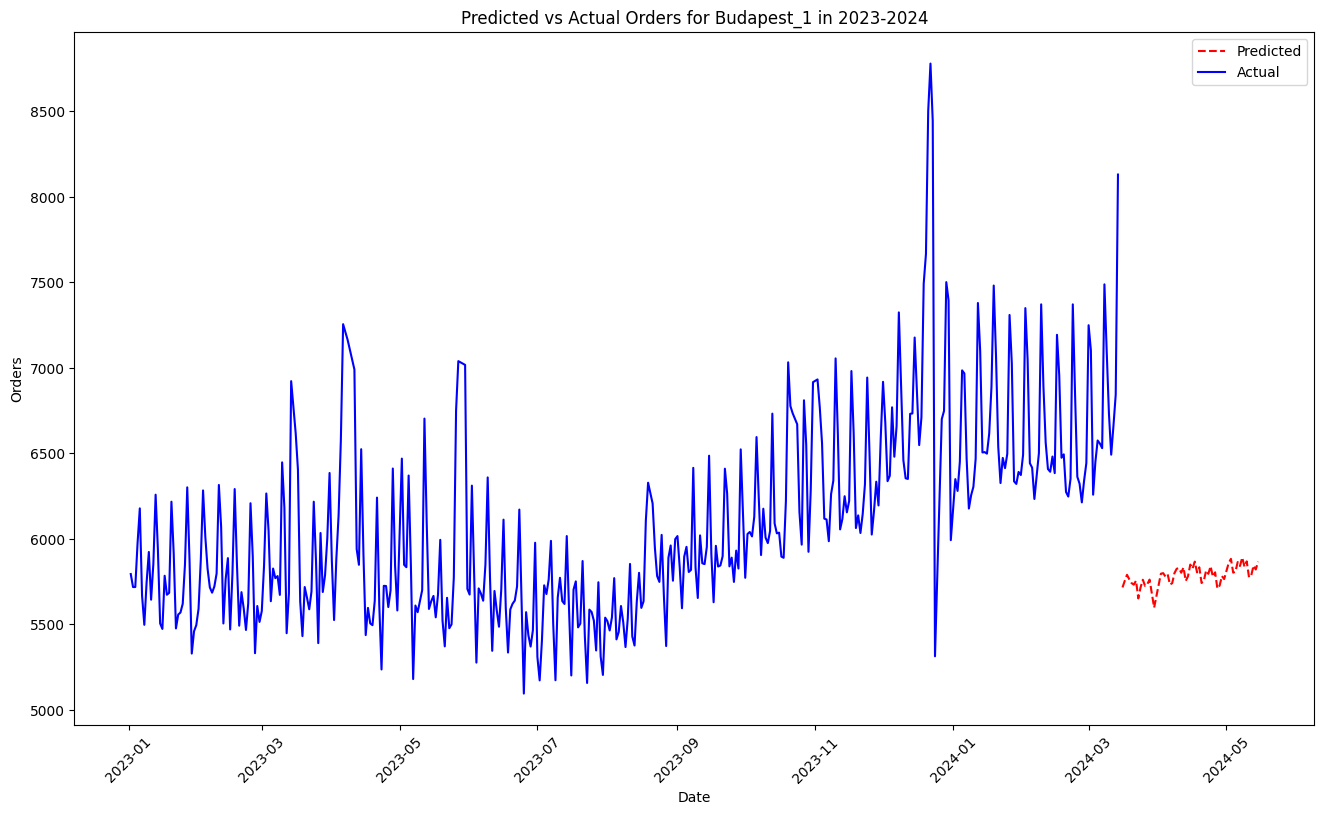

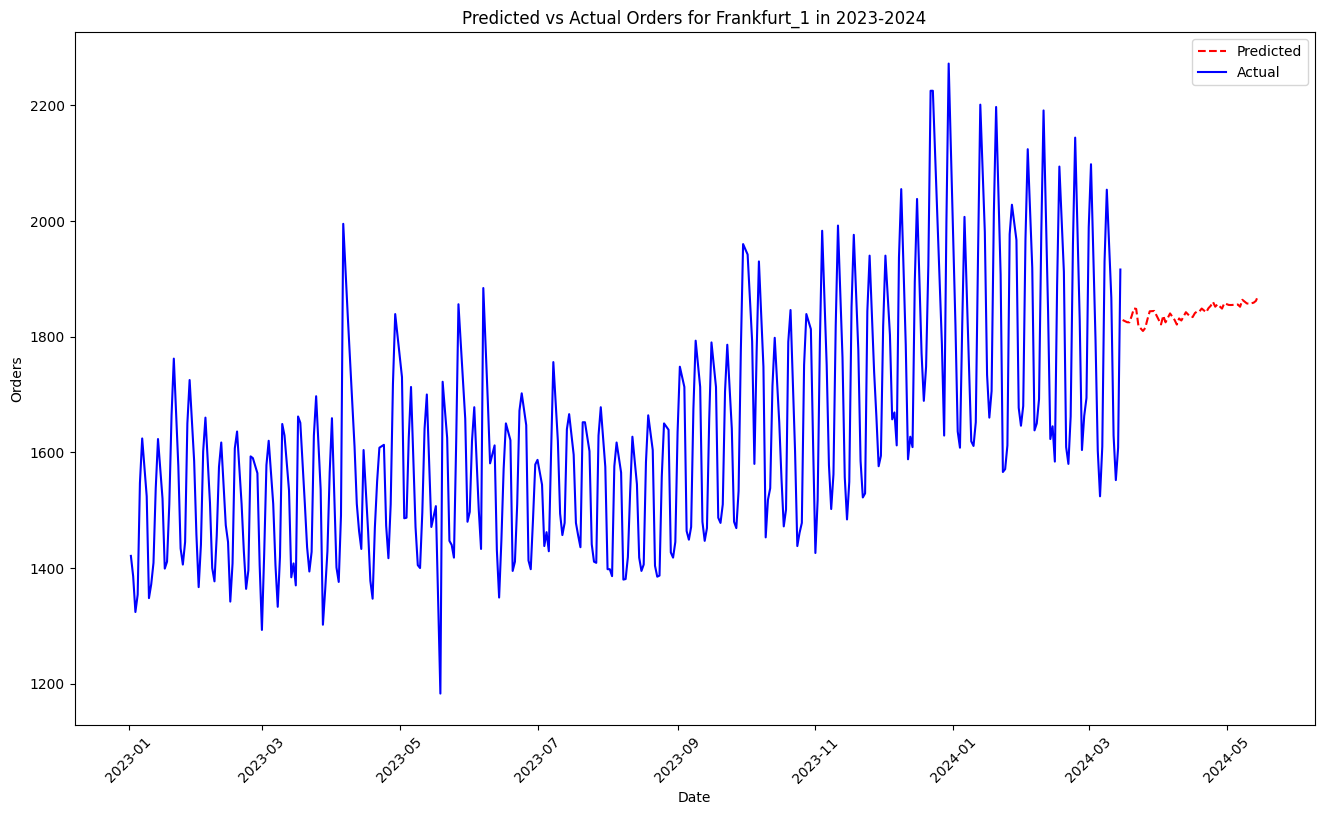

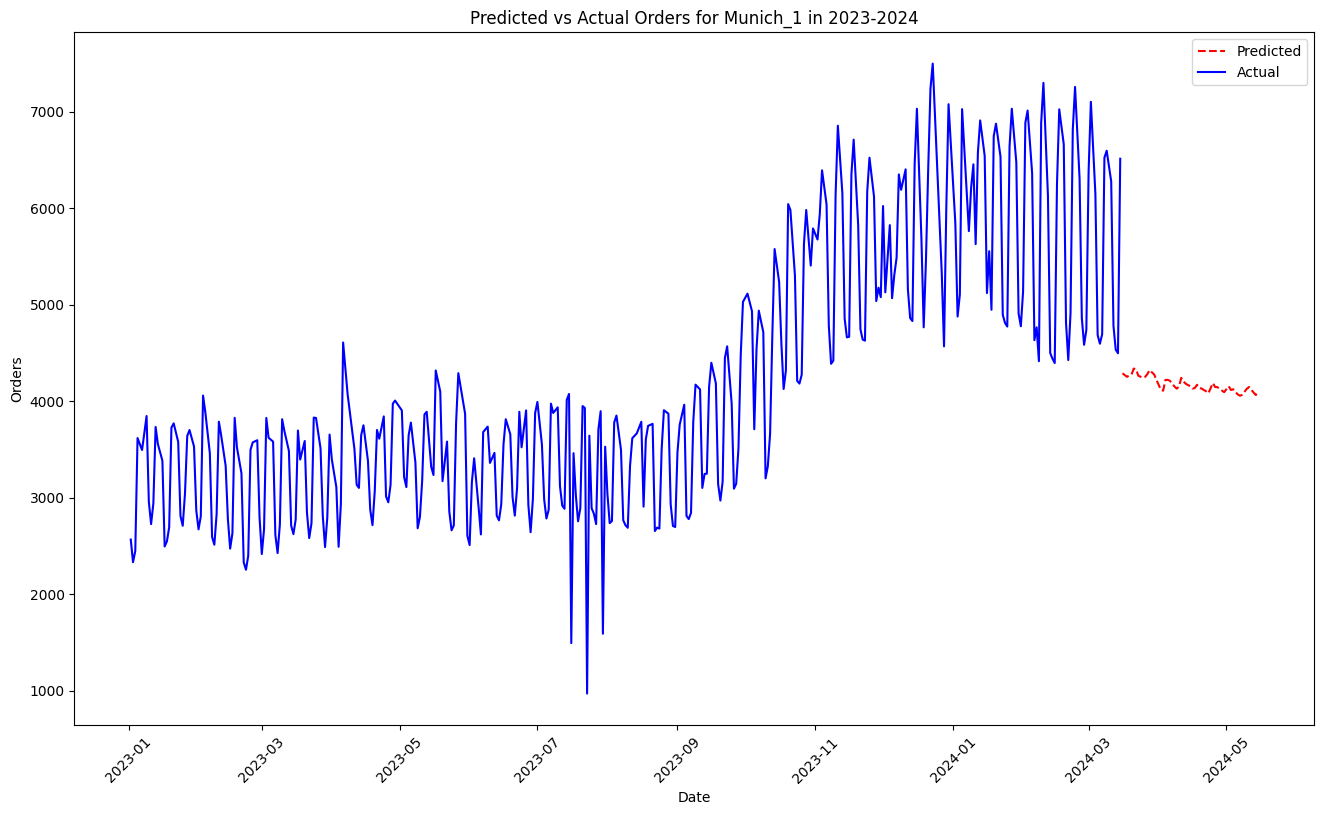

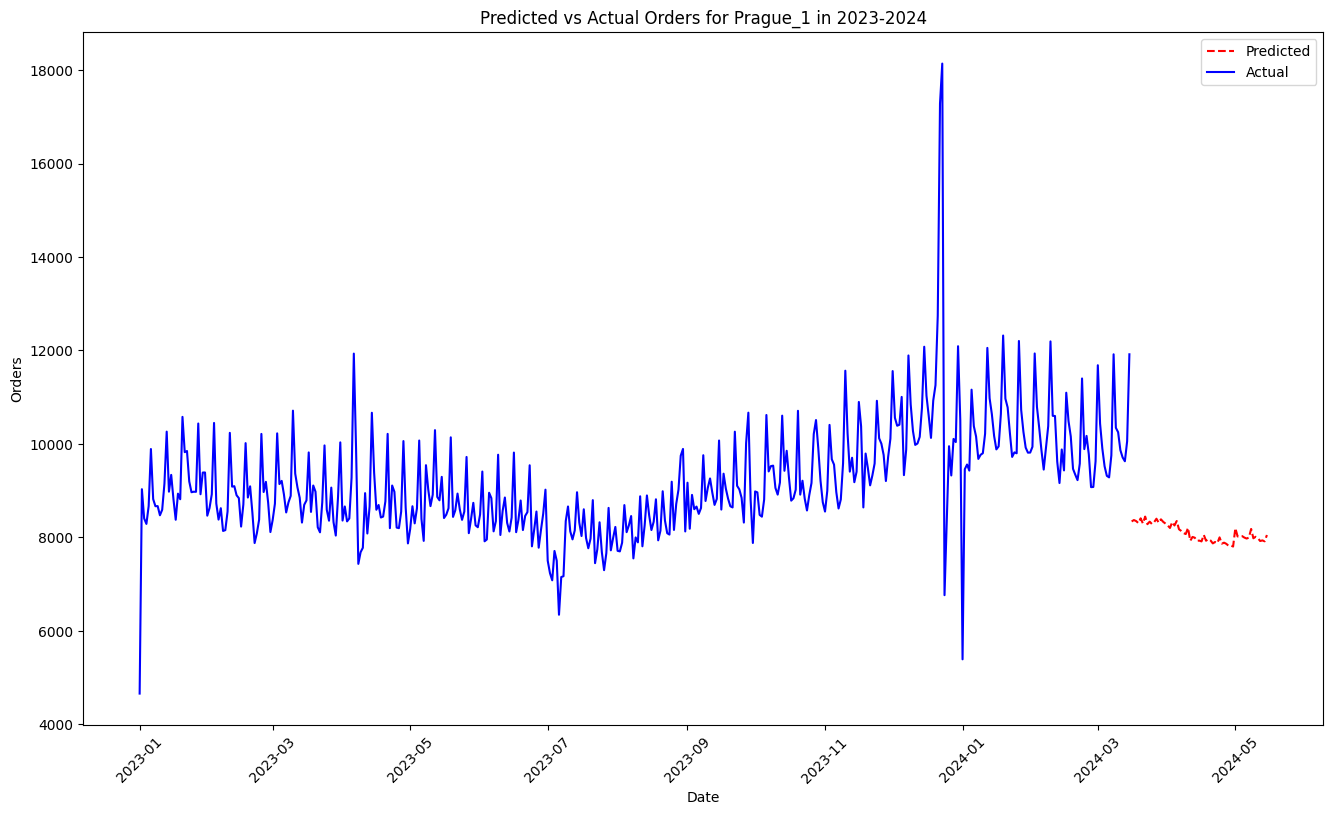

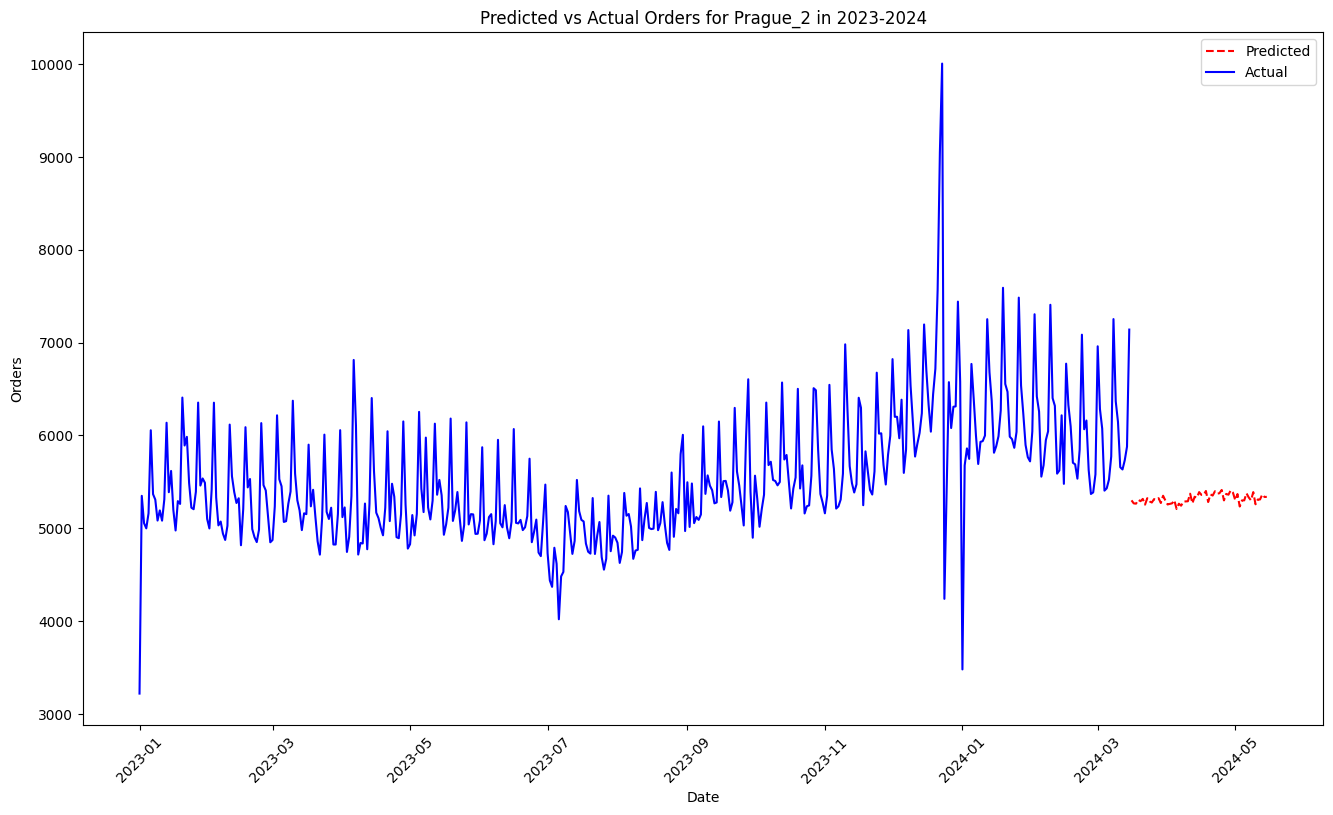

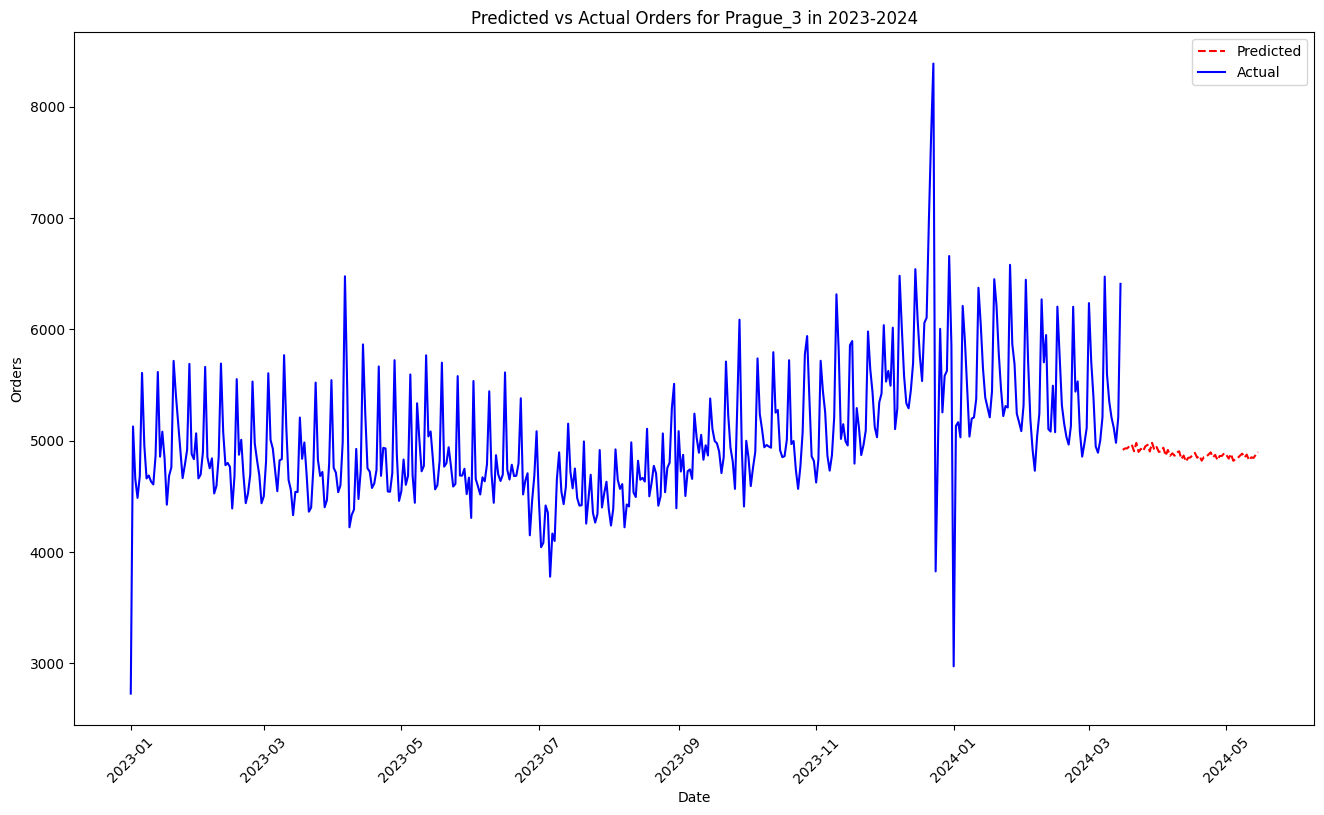

Predictions complete. Submission file and plots created.


In [74]:
# Plot predictions for each warehouse
train_df_raw = pd.read_csv("data/train.csv")
train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])

last_year_data = train_df_raw[train_df_raw['date'].dt.year > 2022]

for wh in warehouses:

    wh_df_pred = submission_df[submission_df['warehouse'] == wh]
    wh_df_last_year = last_year_data[last_year_data['warehouse'] == wh]
    
    # Plot data (training data from 2023)

    plt.figure(figsize=(16, 9))
    
    plt.plot(wh_df_pred.index, wh_df_pred['predicted_orders'], label='Predicted',  linestyle='--', color='red')

    plt.plot(wh_df_last_year.date, wh_df_last_year['orders'], label='Actual', color='blue')

    plt.title(f'Predicted vs Actual Orders for {wh} in 2023-2024')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.xticks(rotation=45)
    plt.savefig(f'prediction_plot_{wh}.png')
    plt.show()
    plt.close()

print("Predictions complete. Submission file and plots created.")